In [261]:
import pandas as pd
import datetime as dt
import numpy as np
import time
import calendar
import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn
import sklearn.ensemble as ens
from sklearn import preprocessing, metrics, cluster
from scipy import stats
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters

sns.set()
colours = sns.color_palette("husl", 8)
cs = [colours[i] for i in range(len(colours))]
sns.set_palette(sns.color_palette(colours))
register_matplotlib_converters()

# Load Data

In [72]:
data = {}
routes = ["452", "9", "52", "267", "277", "7", "14", "35", "37", "69", "328", "6"]

b_452 = pd.read_csv("data/452 07-04-20.csv")
b_52 = pd.read_csv("data/52 07-04-20.csv")
b_7 = pd.read_csv("data/7 07-04-20.csv")
b_14 = pd.read_csv("data/14 07-04-20.csv")
b_9 = pd.read_csv("data/9 07-04-20.csv")
b_328 = pd.read_csv("data/328 07-04-20.csv")
b_69 = pd.read_csv("data/69 07-04-20.csv")
b_35 = pd.read_csv("data/35 07-04-20.csv")
b_37 = pd.read_csv("data/37 07-04-20.csv")
b_267 = pd.read_csv("data/267 07-04-20.csv")
b_277 = pd.read_csv("data/277 07-04-20.csv")
b_6 = pd.read_csv("data/6 07-04-20.csv")

data["452"] = b_452
data["52"] = b_52
data["7"] = b_7
data["9"] = b_9
data["14"] = b_14
data["328"] = b_328
data["267"] = b_267
data["277"] = b_277
data["35"] = b_35
data["37"] = b_37
data["69"] = b_69
data["6"] = b_6

# need to swap the inbound and outbound labels for data before 12/05/20 because 
# I noted them down wrong from the data collection stage
def init_explore(df, route):
    print("BUS ROUTE: ", route)
    print("Shape: ", df.shape)
    df = df.drop(columns = "arrived")
    
    df.loc[df['direction'] == 'out', 'direction'] = 'inbound'
    df.loc[df['direction'] == 'in', 'direction'] = 'outbound'
    df = df[["bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    
    df.rename(columns={'expected_arrival':'time_of_arrival'}, inplace=True)
    df = df.sort_values(by='time_of_arrival', ignore_index=True)
    return df

In [73]:
def add_extra_data(route):
    if route != "6":
        more = pd.read_csv("data/" + route + " 22-04-20.csv")
        more.loc[more['arrived'] == 1, 'arrived'] = True
        more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
        data[route] = data[route].append(more, ignore_index = True)
    
    more = pd.read_csv("data/" + route + " 12-05-20.csv")
    more.loc[more['arrived'] == 1, 'arrived'] = True
    more = more[["arrived", "bus_stop_name", "expected_arrival", "vehicle_id", "time_of_req", "direction"]]
    data[route] = data[route].append(more, ignore_index = True)

In [74]:
for route in routes:
    add_extra_data(route)

In [75]:
for route in routes:
    data[route] = init_explore(data[route], route)

BUS ROUTE:  452
Shape:  (56938, 6)
BUS ROUTE:  9
Shape:  (49935, 6)
BUS ROUTE:  52
Shape:  (92505, 6)
BUS ROUTE:  267
Shape:  (50939, 6)
BUS ROUTE:  277
Shape:  (71103, 6)
BUS ROUTE:  7
Shape:  (43271, 6)
BUS ROUTE:  14
Shape:  (80413, 6)
BUS ROUTE:  35
Shape:  (50120, 6)
BUS ROUTE:  37
Shape:  (78808, 6)
BUS ROUTE:  69
Shape:  (53844, 6)
BUS ROUTE:  328
Shape:  (41514, 6)
BUS ROUTE:  6
Shape:  (84330, 6)


In [76]:
import json

stops_in_sequence_inbound = {}
stops_in_sequence_outbound = {}

for r in routes:
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/inbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_inbound[r] = stops
        
    with urllib.request.urlopen("https://api.tfl.gov.uk/Line/" + r + "/Route/Sequence/outbound") as api:
        print("Making API call to get all stops on route ", r)
        json_data = json.loads(api.read().decode())
        seq = json_data.get("stopPointSequences")
        stops = []
        for s in seq:
            for stop in s.get("stopPoint"):
                name = stop.get("name")
                stops.append(name)
        stops_in_sequence_outbound[r] = stops
        
print(stops_in_sequence_inbound.get("52"))

Making API call to get all stops on route  452
Making API call to get all stops on route  452
Making API call to get all stops on route  9
Making API call to get all stops on route  9
Making API call to get all stops on route  52
Making API call to get all stops on route  52
Making API call to get all stops on route  267
Making API call to get all stops on route  267
Making API call to get all stops on route  277
Making API call to get all stops on route  277
Making API call to get all stops on route  7
Making API call to get all stops on route  7
Making API call to get all stops on route  14
Making API call to get all stops on route  14
Making API call to get all stops on route  35
Making API call to get all stops on route  35
Making API call to get all stops on route  37
Making API call to get all stops on route  37
Making API call to get all stops on route  69
Making API call to get all stops on route  69
Making API call to get all stops on route  328
Making API call to get all stop

In [289]:
stops_452 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_452.csv")
stops_52 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_52.csv")
stops_7 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_7.csv")
stops_14 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_14.csv")
stops_9 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_9.csv")
stops_328 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_328.csv")
stops_69 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_69.csv")
stops_35 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_35.csv")
stops_37 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_37.csv")
stops_267 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_267.csv")
stops_277 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_277.csv")
stops_6 = pd.read_csv("data-collection/valid_stops/valid_stop_ids_6.csv")

stops = {}
stops["452"] = stops_452
stops["52"] = stops_52
stops["7"] = stops_7
stops["9"] = stops_9
stops["14"] = stops_14
stops["328"] = stops_328
stops["267"] = stops_267
stops["277"] = stops_277
stops["35"] = stops_35
stops["37"] = stops_37
stops["69"] = stops_69
stops["6"] = stops_6

# Data Analytics

## Helper Functions

In [160]:
def convert_time_to_datetime(given_time):
    year = int(given_time[:4])
    month = int(given_time[5:7])
    day = int(given_time[8:10])
    hour = int(given_time[11:13])
    minute = int(given_time[14:16])
    second = int(given_time[17:19])

    date_time = dt.datetime(year, month, day, hour, minute, second)
    return date_time

In [164]:
def detect_outlier_z_score(travel_times):
    outlier_indexes = []
    
    threshold = 3
    mean = np.mean(travel_times)
    std = np.std(travel_times)
    
    for i, t in enumerate(travel_times):
        z_score= (t - mean) / std
        
        if np.abs(z_score) > threshold:
            outlier_indexes.append(i)
    
    return outlier_indexes

In [309]:
# Generate list of request times at minutes interval
def generate_request_times(minutes, start, end):
    """
    minutes: frequency of request times e.g. every 15 minutes
    start: start time
    end: end time
    num_times: the number of times to generate
    """
    start = convert_time_to_datetime(start)
    end = convert_time_to_datetime(end)
    req_times = [start]
    
    while start <= end:
        new_time = start + dt.timedelta(minutes = minutes)
        req_times.append(new_time)
        start = new_time
        
    format = '%Y-%m-%d %H:%M:%S'
    req_times_str = [t.strftime(format) for t in req_times]
    return req_times_str

## Predict journey time by taking recent information into account 

### Route 52 Gap of 5: Chesterton Road to Nottinghill Gate Station (inbound)

I am at Nottinghill Gate Station and I want to know what time the next bus will arrive. The current time is X.

I look back 5 stops to find stop A which is the stop which I will use to predict the journey time. Here stop A = Chesterton Road.

1) **Looking back different amounts of time**

- I look at the other buses that have left Chesterton Road and arrived at Nottinghill Gate Station in the past x hours. Weight it so that the journey times in the past 10 minutes weight more than journey times in the past 20 minutes, 20 minutes more than 40 minutes, 40 minutes more than 80 minutes and 80 minutes more than 120 minutes. (Obviously depends on how far back we look, between 15 minutes to 2 hours). Then calculate this weighted average as the predicted journey time for a bus travelling between Chesterton Road and Nottinghill Gate. **predicted journey time = weighted average of past x hours of journey times**

2) **Looking back different numbers of buses**

- I look at the past x buses that have left Chesterton Road and arrived at Nottinghill Gate Station. Weight it so that the journey times for the more recent buses weight more than the journey times of the less recent buses. What counts as 'recent' depends on how many buses back we are looking.

I now try to get the predicted arrival time. So I look for the last bus to leave Chesterton Road and arrive at Nottinghill Gate before the request time. Then I get the next immediate bus that leaves Chesterton Road. This is the one that will be used to predict the arrival time. Add the predicted journey time onto the leave time of this bus + 30 seconds loading/unloading time to get the predicted arrival time. **predicted arrival time = leave time + predicted journey time + 30 seconds**. 

If such a bus doesn't exist, then there is no predicted arrival time, but there is still the predicted journey time. E.g. if I request the time that the nearest bus will arrive at Nottinghill Gate at 03:16:27, then I gather all the buses that arrived at Nottinghill Gate within the past 2 hours that arrived BEFORE 03:16:27. Say the last bus that left Chesterton Road left at 02:45 and arrived at Nottinghill Gate at 03:15. So to get the predicted arrival time, I try to find the next bus to leave Chesterton Road, which is a bus that leaves at 03:17. This time is AFTER the request time so I cannot use this bus in the prediction because it is not the historical data.

Length of unloading/loading time for passengers at a bus stop can be a hyperparameter to tune later on. Right now is set to 30 seconds. This can be adjusted to see varying accuracy?

I now get the actual arrival time. The same bus that we used to calculate the predicted arrival time, we track its vehicle id in the entries for Nottinghill Gate and look for its actual arrival time. Get the actual journey time by subtracting the leave time from the actual arrival time. **actual journey time = actual arrival time - leave time**

To evaluate success, plot the predicted journey journey time against the actual journey time and could calculate the MAPE or something along those lines.

In [189]:
stop_a_name52 = stops_in_sequence_inbound.get("52")[16]
stop_b_name52 = stops_in_sequence_inbound.get("52")[21]

print(stop_a_name52, stops_in_sequence_inbound.get("52").index("Chesterton Road"))
print(stop_b_name52, stops_in_sequence_inbound.get("52").index("Notting Hill Gate Station"))

Chesterton Road 16
Notting Hill Gate Station 21


In [291]:
b_52 = data["52"]

stop_a52 = b_52.loc[(b_52['bus_stop_name'] == stop_a_name52) & (b_52['direction'] == 'inbound')]

xid = stops_52.loc[(stops_52['stop_name'] == stop_a_name52) & (stops_52['direction'] == 'inbound')]
xid = xid.get('stop_id').values[0]
print("inbound id: ", xid)

[_, stop_a_id52, _, _, _] = stop_a52.iloc[0]['vehicle_id'].split('_')
print(stop_a52.shape)
print("found id: ", stop_a_id52)
stop_a52.head()

inbound id:  490005139C
(1351, 5)
found id:  490005139C


,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
50,Chesterton Road,2020-04-16 02:53:40,11536_490005139C_2020-04-16_out_0,2020-04-16 02:49:22,inbound
51,Chesterton Road,2020-04-16 02:53:40,11536_490005139C_2020-04-16_out_0,2020-04-16 02:49:22,inbound
198,Chesterton Road,2020-04-16 03:24:17,10292_490005139C_2020-04-16_out_0,2020-04-16 03:21:47,inbound
199,Chesterton Road,2020-04-16 03:24:17,10292_490005139C_2020-04-16_out_0,2020-04-16 03:21:47,inbound
296,Chesterton Road,2020-04-16 03:41:35,11808_490005139C_2020-04-16_out_0,2020-04-16 03:40:29,inbound


In [292]:
stop_b52 = b_52.loc[(b_52['bus_stop_name'] == stop_b_name52) & (b_52['direction'] == 'inbound')]

xid = stops_52.loc[(stops_52['stop_name'] == stop_b_name52) & (stops_52['direction'] == 'inbound')]
xid = xid.get('stop_id').values[0]
print("inbound id: ", xid)

[_, stop_b_id52, _, _, _] = stop_b52.iloc[0]['vehicle_id'].split('_')
print(stop_b52.shape)
# outbound id
print("found id: ", stop_b_id52)
stop_b52.head()

inbound id:  490015039C
(1360, 5)
found id:  490000167G


,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
70,Notting Hill Gate Station,2020-04-16 02:58:29,11536_490000167G_2020-04-16_out_0,2020-04-16 02:44:26,inbound
71,Notting Hill Gate Station,2020-04-16 02:58:29,11536_490000167G_2020-04-16_out_0,2020-04-16 02:44:26,inbound
216,Notting Hill Gate Station,2020-04-16 03:29:24,10292_490000167G_2020-04-16_out_0,2020-04-16 03:14:04,inbound
217,Notting Hill Gate Station,2020-04-16 03:29:24,10292_490000167G_2020-04-16_out_0,2020-04-16 03:14:04,inbound
330,Notting Hill Gate Station,2020-04-16 03:45:43,11808_490000167G_2020-04-16_out_0,2020-04-16 03:40:51,inbound


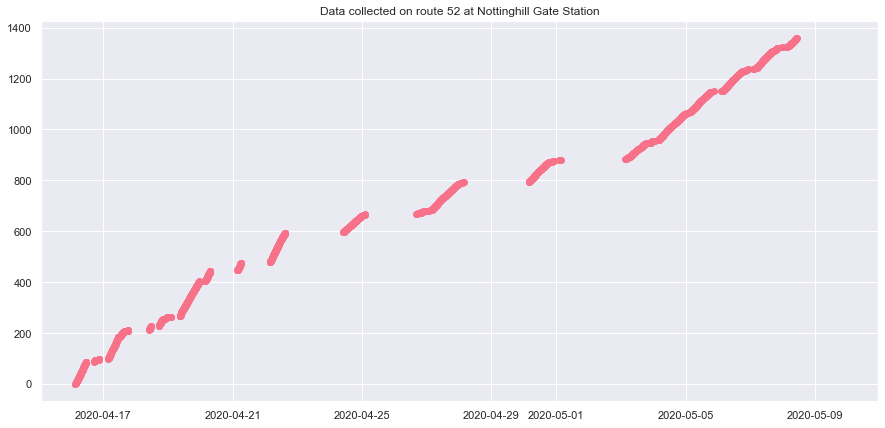

In [192]:
fig, ax = plt.subplots(figsize=(15,7))
x = [convert_time_to_datetime(i) for i in stop_b52['time_of_arrival']]
ax.scatter(x, [i for i in range(0, len(x))])
ax.set_xlim([dt.datetime(2020, 4, 15, 2), dt.datetime(2020, 5, 10, 22, 59, 59)])
ax.set_title("Data collected on route 52 at Nottinghill Gate Station")
plt.show()

In [294]:
def predict_arrival_time(req_time, leave_stop, pred_jrny_time, most_recent_left):
    """
    Params
    - req_time: the time of request
    - leave_stop: stop that is being used to find the bus to track i.e. stop_a
    - pred_jrny_time: predicted journey time
    - most_recent_left: the index of the bus that left leave_stop the last but
    arrived at stop_a before the request time.
    
    Returns
    - the predicted arrival time of the bus at stop B
    - the actual vehicle that is being tracked.
    """
    
    req_time = convert_time_to_datetime(req_time)

    for i, bus in leave_stop.iterrows():
        if i > most_recent_left:
            # Ensures that it will arrive at stop b either ON or AFTER req_time
            leave_time = convert_time_to_datetime(bus['time_of_arrival'])
            # This vehicle is the one that left immediately after

            if leave_time <= req_time:
                # 30 second leeway for loading and unloading passengers
                pred_arrival = leave_time + dt.timedelta(seconds = (pred_jrny_time + 30))
                return pred_arrival, bus
            # else: The nearest vehicle left stop a after the request time, so this wouldn't count as historical data
                
    # most_recent_left is the last item in the list already
    print("There are no buses due at this time from this stop")    
    return 0, []

In [295]:
def get_actual_times(arr_stop, req_time, bus_to_track, arr_stop_id):
    """
    Params:
    - arr_stop: arrival stop = stop_b
    - req_time: time of request
    - bus_to_track: the bus that is being tracked to find its actual arrival time
    - arr_stop_id: stop b id
    
    Returns the arrival time and journey time (seconds) of the first bus that arrives 
    at arr_stop immediately after req_time.
    Returns -1, -1 if there is no bus that arrives after req_time.
    """
    
    [bus_id, a_id, date, _, _] = bus_to_track['vehicle_id'].split('_')
    to_match_id = bus_id + '_' + arr_stop_id + '_' + date + '_'
    leave_time = convert_time_to_datetime(bus_to_track['time_of_arrival'])
    
    req_time = convert_time_to_datetime(req_time)
    for i, bus in arr_stop.iterrows():
        actual_arr_time = convert_time_to_datetime(bus['time_of_arrival'])
        
        if bus['vehicle_id'].startswith(to_match_id):
            
            if actual_arr_time > req_time:
                
                actual_jrny_time = actual_arr_time - leave_time + dt.timedelta(seconds = 30)
                
                # REMINDER: this is only fine because the 2 stops I chose are about 5 minutes apart
                if (actual_jrny_time > dt.timedelta(minutes = 10)) or (actual_jrny_time < dt.timedelta(minutes = 3)):
                    return -1, -1
                
                print("Actual journey time is {}".format(actual_jrny_time))
                return actual_arr_time, actual_jrny_time
        
    return -1, -1

In [296]:
def pred_eval_times_mult(req_time, stop_a, stop_b, a_id, b_id, time_back, buses_back):
    """
    Use for testing and training
    
    If I request the arrival time of a bus at stop B at req_time, what is the predicted
    arrival time and journey time of the nearest bus?
    
    Returns the predicted and actual arrival time of a bus at stop B, as well as the
    predicted and actual journey time of a bus from stop A to stop B in seconds.
    
    If the actual bus data cannot be found, return 0s all around.
    
    """
    
    print("Request time is ", req_time)
    pred_jrny_time = 0
    
    if buses_back == -1:
        # option 1) look back x hours
        pred_jrny_time, most_recent_left = predict_journey_time_time_back(req_time, stop_a, stop_b, a_id, time_back)
    else:
        # option 2) look back x buses TODO
        pred_jrny_time, most_recent_left = predict_journey_time_buses_back(req_time, stop_a, stop_b, a_id, buses_back)
        
    print("Predicted journey time is ", (pred_jrny_time / 60))
    
    if pred_jrny_time == 0:
        # Can't find any journeys
        return 0, 0, 0, 0
    
    pred_arr, bus_to_track = predict_arrival_time(req_time, stop_a, pred_jrny_time, most_recent_left)
    
    if isinstance(bus_to_track, list):
        # Can't find correlating leaving bus
        return pred_arr, 0, 0, 0
    
    actual_arr, actual_jrny_time = get_actual_times(stop_b, req_time, bus_to_track, b_id)
    
    if actual_arr == -1:
        # There is no bus arriving at req_time
        return pred_arr, 0, 0, 0
    
    return pred_arr, actual_arr, pred_jrny_time, actual_jrny_time

In [297]:
def eval_historical_model(time_back, buses_back, req_times, stopa, stopb, stop_aid, stop_bid):
    preds = []
    accs = []
    req_timesx = []
    preds_jrny = []
    accs_jrny = []

    start = time.time()
    for req_time in req_times:
        pt, at, pj, aj = pred_eval_times_mult(req_time, stopa, stopb, stop_aid, stop_bid, time_back, buses_back)
        if at == 0:
            continue

        req_timesx.append(req_time)
        preds.append(pt)
        accs.append(at)
        preds_jrny.append(pj / 60)
        accs_jrny.append(aj / 60)
    
    print("Total time taken: ", (time.time() - start))
    return preds, accs, req_timesx, preds_jrny, accs_jrny

### Look back different amounts of time
1) 15 minutes

2) 30 minutes

3) 1 hour

4) 2 hours

In [245]:
def get_times_past_x_minutes(stop_a, stop_b, a_id, req_time, time_back):
    
    """
    journey_times 
        - is a list of journey times for a bus arriving at stop b within the past time_back 
        minutes of the request time. (not including the request time)
    most_recent_left
        - is the last vehicle to leave stop a and arrive at stop b before req_time. Returns -1
        if no vehicle arrived at stop b within the past time_back hours, but before the req_time. 
        This could occur in cases where a request is made e.g. at 3 am and the bus is not a 24h bus.
    arrived_journeys
        - is a list of bus details for vehicles arriving at stop b within the past time_back 
        hours of the request time. Bus details include vehicle id.
    """

    journey_times = []
    most_recent_left = -1
    arrived_journeys = []
    req_time = convert_time_to_datetime(req_time)
    count = 0
    count1 = 0
    count2 = 0

    for i, journey in stop_b.iterrows():
        arr_dt = convert_time_to_datetime(journey['time_of_arrival'])
        past_x_hours = req_time - dt.timedelta(minutes = time_back)

        if (arr_dt >= past_x_hours) & (arr_dt < req_time):
            count = count + 1
            # arrived within past time_back hours and before request time
            [bus_id, b_id, date, direction, _] = journey['vehicle_id'].split('_')
            to_match_id = bus_id + '_' + a_id + '_' + date + '_' + direction + '_'
            
            for j, match in stop_a.iterrows():
                if match['vehicle_id'].startswith(to_match_id):
                    # vehicle id matches
                    count1 = count1 + 1
                    leave_dt = convert_time_to_datetime(match['time_of_arrival'])
                    journey_time = arr_dt - leave_dt

                    if (journey_time > dt.timedelta(minutes = 0)) & (journey_time < dt.timedelta(minutes = 15)):
                        # journey time is feasible as being the same journey
                        count2 = count2 + 1
                        most_recent_left = j
                        arrived_journeys.append(journey)
                        journey_times.append(journey_time)
                        
    print("Number of buses that arrived at stop b within the past {} minutes: {}".format(time_back, count))
    print("Number of buses that left stop a and have an id match: ", count1)
    print("Number of buses that have feasible journey times: ", count2)
        
    return most_recent_left, arrived_journeys, journey_times

In [246]:
def predict_journey_time_time_back(req_time, stop_a, stop_b, a_id, time_back):
    """
    - A request for the predicted journey time of a bus arriving at stop b is 
    made at req_time
    - Returns the predicted journey time based on journey times in the past x hours.
    - Journey times from the past time_back minutes are weighted depending on how long ago
    they were compared to the request time.
    - most_recent_left is the the last bus that left stop a and arrived at stop be before
    req_time.

    """
    weights_15 = {"10": 0.65, "20": 0.35}
    weights_30 = {"10": 0.65, "20": 0.3, "40": 0.05}
    weights_60 = {"10": 0.65, "20": 0.2, "40": 0.1, "80": 0.05}
    weights_120 = {"10": 0.65, "20": 0.18, "40": 0.1, "80": 0.05, "120": 0.02}
    
    weights = weights_120
    
    most_recent_left_indx, arrived, journey_times = get_times_past_x_minutes(stop_a, stop_b, a_id, req_time, time_back)
    
    if time_back == 15:
        weights = weights_15
    elif time_back == 30:
        weights = weights_30
    elif time_back == 60:
        weights = weights_60
    
    pred = 0
    sum_weights = 0
    for index, item in enumerate(arrived):
        eta = convert_time_to_datetime(item["time_of_arrival"])
        diff = convert_time_to_datetime(req_time) - eta
        weight = 0
        if (diff <= dt.timedelta(minutes = 120)) & (diff > dt.timedelta(minutes = 80)):
            weight = weights["120"]
        elif (diff <= dt.timedelta(minutes = 80)) & (diff > dt.timedelta(minutes = 40)):
            weight = weights["80"]
        elif (diff <= dt.timedelta(minutes = 40)) & (diff > dt.timedelta(minutes = 20)):
            weight = weights["40"]
        elif (diff <= dt.timedelta(minutes = 20)) & (diff > dt.timedelta(minutes = 10)):
            weight = weights["20"]
        elif (diff <= dt.timedelta(minutes = 10)) & (diff > dt.timedelta(minutes = 0)):
            weight = weights["10"]
        journey_time = journey_times[index].total_seconds()
        pred += weight * journey_time
        sum_weights += weight
    
    if (sum_weights == 0) or (most_recent_left_indx == -1):
        return pred, most_recent_left_indx
    
    pred = pred / sum_weights
    
    return pred, most_recent_left_indx

In [247]:
# Getting predicted arrival times for buses on route 52 for a gap of 5 stops.
"""
preds_52 = predicted arrival times (datetime)
accs_52 = actual arrival times (datetime)
req_timesx_52 = request times that returned valid values
preds_jrny_52 = predicted journey times (float in minutes)
accs_jrny_52 = actual journey times (timedelta in minutes)
"""

req_times_52 = generate_request_times(30, "2020-05-03 02:00:00", "2020-05-08 23:59:59")

# looking at journeys in the past 2 hours
_, _, req_timesx_52_120m, preds_jrny_52_120m, accs_jrny_52_120m = eval_historical_model(120, -1, req_times_52, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

Request time is  2020-05-03 02:00:00
Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-03 02:30:00
Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-03 03:00:00
Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses that left stop a and have an id match:  5
Number of buses that have feasible journey times:  1
Predicted journey time is  3.8333333333333335
There are no buses due at this time from this stop
Request time is  2020-05-03 03:30:00
Number of buses that arrived at stop b within the past 120 minutes: 1
Number of buses that left stop a and have an id match:  5
Number of buses that h

Actual journey time is 0:07:40
Request time is  2020-05-03 16:00:00
Number of buses that arrived at stop b within the past 120 minutes: 8
Number of buses that left stop a and have an id match:  44
Number of buses that have feasible journey times:  8
Predicted journey time is  6.110541310541311
There are no buses due at this time from this stop
Request time is  2020-05-03 16:30:00
Number of buses that arrived at stop b within the past 120 minutes: 8
Number of buses that left stop a and have an id match:  48
Number of buses that have feasible journey times:  8
Predicted journey time is  6.319711538461538
Actual journey time is 0:05:33
Request time is  2020-05-03 17:00:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  55
Number of buses that have feasible journey times:  10
Predicted journey time is  5.89516129032258
There are no buses due at this time from this stop
Request time is  2020-05-03 17:30:00
Number

Actual journey time is 0:04:56
Request time is  2020-05-04 06:00:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  81
Number of buses that have feasible journey times:  10
Predicted journey time is  4.529227053140096
Actual journey time is 0:05:14
Request time is  2020-05-04 06:30:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  81
Number of buses that have feasible journey times:  10
Predicted journey time is  4.739285714285714
Actual journey time is 0:05:06
Request time is  2020-05-04 07:00:00
Number of buses that arrived at stop b within the past 120 minutes: 12
Number of buses that left stop a and have an id match:  84
Number of buses that have feasible journey times:  12
Predicted journey time is  5.162630208333335
Actual journey time is 0:04:49
Request time is  2020-05-04 07:30:00
Number of buses that arrived at stop b wi

Actual journey time is 0:06:00
Request time is  2020-05-04 19:30:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  86
Number of buses that have feasible journey times:  9
Predicted journey time is  5.5813559322033885
There are no buses due at this time from this stop
Request time is  2020-05-04 20:00:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  89
Number of buses that have feasible journey times:  9
Predicted journey time is  5.010714285714286
Actual journey time is 0:04:08
Request time is  2020-05-04 20:30:00
Number of buses that arrived at stop b within the past 120 minutes: 11
Number of buses that left stop a and have an id match:  89
Number of buses that have feasible journey times:  10
Predicted journey time is  3.881007751937984
There are no buses due at this time from this stop
Request time is  2020-05-04 21:00:00
Nu

Actual journey time is 0:06:44
Request time is  2020-05-05 09:00:00
Number of buses that arrived at stop b within the past 120 minutes: 12
Number of buses that left stop a and have an id match:  79
Number of buses that have feasible journey times:  12
Predicted journey time is  5.02450248756219
Actual journey time is 0:09:58
Request time is  2020-05-05 09:30:00
Number of buses that arrived at stop b within the past 120 minutes: 12
Number of buses that left stop a and have an id match:  74
Number of buses that have feasible journey times:  12
Predicted journey time is  5.351526717557252
There are no buses due at this time from this stop
Request time is  2020-05-05 10:00:00
Number of buses that arrived at stop b within the past 120 minutes: 12
Number of buses that left stop a and have an id match:  77
Number of buses that have feasible journey times:  11
Predicted journey time is  4.466391184573003
Actual journey time is 0:04:12
Request time is  2020-05-05 10:30:00
Number of buses that a

Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-05 23:30:00
Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-06 00:00:00
Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-06 00:30:00
Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-06 01:00:00
Numb

Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  63
Number of buses that have feasible journey times:  10
Predicted journey time is  7.302284946236557
There are no buses due at this time from this stop
Request time is  2020-05-06 13:30:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  65
Number of buses that have feasible journey times:  10
Predicted journey time is  7.319540229885058
Actual journey time is 0:05:30
Request time is  2020-05-06 14:00:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  65
Number of buses that have feasible journey times:  10
Predicted journey time is  7.123387096774192
Actual journey time is 0:08:09
Request time is  2020-05-06 14:30:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses th

Number of buses that arrived at stop b within the past 120 minutes: 3
Number of buses that left stop a and have an id match:  4
Number of buses that have feasible journey times:  2
Predicted journey time is  4.73888888888889
There are no buses due at this time from this stop
Request time is  2020-05-07 04:00:00
Number of buses that arrived at stop b within the past 120 minutes: 2
Number of buses that left stop a and have an id match:  3
Number of buses that have feasible journey times:  2
Predicted journey time is  4.522222222222222
There are no buses due at this time from this stop
Request time is  2020-05-07 04:30:00
Number of buses that arrived at stop b within the past 120 minutes: 3
Number of buses that left stop a and have an id match:  11
Number of buses that have feasible journey times:  3
Predicted journey time is  3.7646666666666664
There are no buses due at this time from this stop
Request time is  2020-05-07 05:00:00
Number of buses that arrived at stop b within the past 12

Number of buses that arrived at stop b within the past 120 minutes: 8
Number of buses that left stop a and have an id match:  46
Number of buses that have feasible journey times:  8
Predicted journey time is  5.8930894308943085
Request time is  2020-05-07 17:30:00
Number of buses that arrived at stop b within the past 120 minutes: 6
Number of buses that left stop a and have an id match:  34
Number of buses that have feasible journey times:  6
Predicted journey time is  6.052777777777778
Request time is  2020-05-07 18:00:00
Number of buses that arrived at stop b within the past 120 minutes: 5
Number of buses that left stop a and have an id match:  27
Number of buses that have feasible journey times:  5
Predicted journey time is  4.576591760299625
Actual journey time is 0:07:45
Request time is  2020-05-07 18:30:00
Number of buses that arrived at stop b within the past 120 minutes: 5
Number of buses that left stop a and have an id match:  30
Number of buses that have feasible journey time

Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  35
Number of buses that have feasible journey times:  10
Predicted journey time is  5.213362068965517
There are no buses due at this time from this stop
Request time is  2020-05-08 08:00:00
Number of buses that arrived at stop b within the past 120 minutes: 9
Number of buses that left stop a and have an id match:  31
Number of buses that have feasible journey times:  9
Predicted journey time is  5.07688679245283
Actual journey time is 0:03:23
Request time is  2020-05-08 08:30:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that left stop a and have an id match:  35
Number of buses that have feasible journey times:  10
Predicted journey time is  4.461594202898551
Actual journey time is 0:05:46
Request time is  2020-05-08 09:00:00
Number of buses that arrived at stop b within the past 120 minutes: 10
Number of buses that 

Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-09 00:00:00
Number of buses that arrived at stop b within the past 120 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Total time taken:  383.5694360733032


In [248]:
len(preds_jrny_52)

83

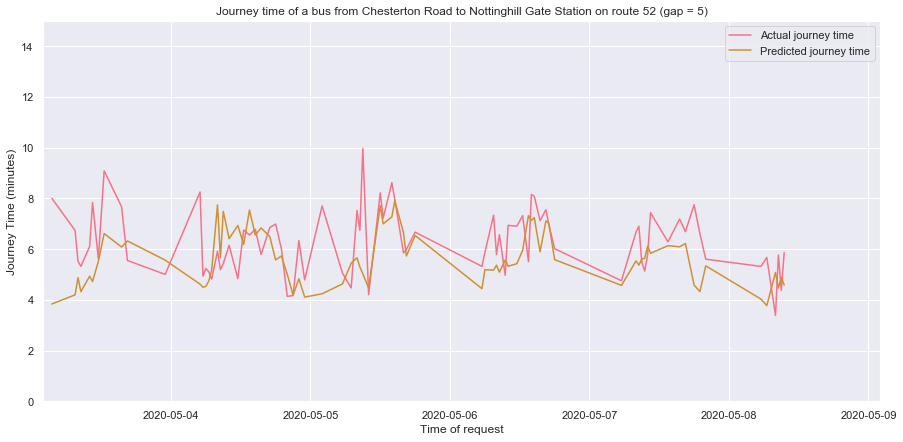

In [267]:
times_52_120m = [convert_time_to_datetime(t) for t in req_timesx_52_120m]
actual_jrny_52_120m = [x.total_seconds() for x in accs_jrny_52_120m]

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(times_52_120m, actual_jrny_52_120m, label="Actual journey time")
ax.plot(times_52_120m, preds_jrny_52_120m, label="Predicted journey time")
ax.set_xlabel("Time of request")
ax.set_ylabel("Journey Time (minutes)")
ax.set_ylim(0, 15)
ax.set_xlim([dt.datetime(2020, 5, 3, 2), dt.datetime(2020, 5, 9, 2)])
ax.set_title("Journey time of a bus from Chesterton Road to Nottinghill Gate Station on route 52 (gap = 5)")
ax.legend()

plt.show()

In [250]:
# looking at journeys in the past 15 minutes
_, _, req_timesx_52_15m, preds_jrny_52_15m, accs_jrny_52_15m = eval_historical_model(15, -1, req_times_52, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

# looking at journeys in the past 30 minutes
_, _, req_timesx_52_30m, preds_jrny_52_30m, accs_jrny_52_30m = eval_historical_model(30, -1, req_times_52, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

# looking at journeys in the past 60 minutes
_, _, req_timesx_52_60m, preds_jrny_52_60m, accs_jrny_52_60m = eval_historical_model(60, -1, req_times_52, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

Request time is  2020-05-03 02:00:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-03 02:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-03 03:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  5
Number of buses that have feasible journey times:  1
Predicted journey time is  3.8333333333333335
There are no buses due at this time from this stop
Request time is  2020-05-03 03:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have 

Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  6.4
Actual journey time is 0:05:33
Request time is  2020-05-03 17:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  5
Number of buses that have feasible journey times:  1
Predicted journey time is  6.016666666666667
There are no buses due at this time from this stop
Request time is  2020-05-03 17:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  6.183333333333334
There are no buses due at this time from this stop
Request time is  2020-05-03 18:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left 

Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  20
Number of buses that have feasible journey times:  2
Predicted journey time is  4.973333333333333
There are no buses due at this time from this stop
Request time is  2020-05-04 08:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  10
Number of buses that have feasible journey times:  1
Predicted journey time is  10.233333333333333
Actual journey time is 0:05:55
Request time is  2020-05-04 08:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  10
Number of buses that have feasible journey times:  1
Predicted journey time is  4.766666666666667
Actual journey time is 0:05:11
Request time is  2020-05-04 09:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left st

Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  2
Number of buses that have feasible journey times:  1
Predicted journey time is  5.75
There are no buses due at this time from this stop
Request time is  2020-05-04 22:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  2
Number of buses that have feasible journey times:  1
Predicted journey time is  5.05
Actual journey time is 0:06:20
Request time is  2020-05-04 22:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  1
Predicted journey time is  1.9499999999999997
There are no buses due at this time from this stop
Request time is  2020-05-04 23:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and 

Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  5
Number of buses that have feasible journey times:  1
Predicted journey time is  6.916666666666667
Request time is  2020-05-05 12:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  3
Number of buses that have feasible journey times:  1
Predicted journey time is  7.750000000000001
Actual journey time is 0:08:13
Request time is  2020-05-05 12:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  1
Predicted journey time is  6.383333333333334
Actual journey time is 0:07:13
Request time is  2020-05-05 13:00:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  9
Number of buses that have

Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-06 03:00:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-06 03:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-06 04:00:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  11
Number of buses that have feasible journey times:  2
Predicted journey time is  4.208333333333333
There are no buses due at this

Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  1
Predicted journey time is  7.666666666666667
Actual journey time is 0:07:33
Request time is  2020-05-06 17:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  1
Predicted journey time is  7.616666666666666
Actual journey time is 0:06:58
Request time is  2020-05-06 17:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-06 18:00:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible jour

Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  13
Number of buses that have feasible journey times:  2
Predicted journey time is  5.761666666666667
Actual journey time is 0:06:40
Request time is  2020-05-07 08:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  1
Predicted journey time is  5.183333333333334
Actual journey time is 0:06:54
Request time is  2020-05-07 09:00:00
Number of buses that arrived at stop b within the past 15 minutes: 2
Number of buses that left stop a and have an id match:  14
Number of buses that have feasible journey times:  2
Predicted journey time is  5.718333333333334
Actual journey time is 0:05:29
Request time is  2020-05-07 09:30:00
Number of buses that arrived at stop b within the past 15 minutes: 1
Number of buses that left stop a and have an id ma

Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-07 23:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 00:00:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 00:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 01:00:00
Number o

Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 14:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 15:00:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 15:30:00
Number of buses that arrived at stop b within the past 15 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 16:00:00
Number o

Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  1
Predicted journey time is  4.316666666666666
Actual journey time is 0:06:44
Request time is  2020-05-03 08:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  16
Number of buses that have feasible journey times:  2
Predicted journey time is  5.583333333333333
Actual journey time is 0:05:31
Request time is  2020-05-03 08:30:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  16
Number of buses that have feasible journey times:  3
Predicted journey time is  3.6999999999999997
Actual journey time is 0:05:19
Request time is  2020-05-03 09:00:00
Number of buses that arrived at stop b within the past 30 minutes: 4
Number of buses that left stop a and have an id m

Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  1
Predicted journey time is  4.883333333333334
There are no buses due at this time from this stop
Request time is  2020-05-03 22:30:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  13
Number of buses that have feasible journey times:  2
Predicted journey time is  6.110526315789474
There are no buses due at this time from this stop
Request time is  2020-05-03 23:00:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  11
Number of buses that have feasible journey times:  1
Predicted journey time is  4.916666666666667
Actual journey time is 0:05:00
Request time is  2020-05-03 23:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of 

Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  18
Number of buses that have feasible journey times:  2
Predicted journey time is  6.853571428571429
Actual journey time is 0:06:45
Request time is  2020-05-04 13:00:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  15
Number of buses that have feasible journey times:  2
Predicted journey time is  7.0928571428571425
There are no buses due at this time from this stop
Request time is  2020-05-04 13:30:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  24
Number of buses that have feasible journey times:  2
Predicted journey time is  8.072807017543859
Actual journey time is 0:06:33
Request time is  2020-05-04 14:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left st

Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  7
Number of buses that have feasible journey times:  2
Predicted journey time is  5.079761904761904
There are no buses due at this time from this stop
Request time is  2020-05-05 03:00:00
Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  1
Predicted journey time is  5.383333333333334
There are no buses due at this time from this stop
Request time is  2020-05-05 03:30:00
Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  3
Number of buses that have feasible journey times:  1
Predicted journey time is  4.566666666666666
There are no buses due at this time from this stop
Request time is  2020-05-05 04:00:00
Number of buses that arrived at stop b within the past 30 min

Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  15
Number of buses that have feasible journey times:  3
Predicted journey time is  5.560833333333333
Actual journey time is 0:05:59
Request time is  2020-05-05 17:00:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  10
Number of buses that have feasible journey times:  2
Predicted journey time is  6.117857142857142
There are no buses due at this time from this stop
Request time is  2020-05-05 17:30:00
Number of buses that arrived at stop b within the past 30 minutes: 4
Number of buses that left stop a and have an id match:  26
Number of buses that have feasible journey times:  4
Predicted journey time is  6.792948717948717
There are no buses due at this time from this stop
Request time is  2020-05-05 18:00:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of

Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  6
Number of buses that have feasible journey times:  1
Predicted journey time is  5.316666666666666
Actual journey time is 0:07:20
Request time is  2020-05-06 08:00:00
Number of buses that arrived at stop b within the past 30 minutes: 5
Number of buses that left stop a and have an id match:  27
Number of buses that have feasible journey times:  5
Predicted journey time is  5.337121212121212
Actual journey time is 0:05:47
Request time is  2020-05-06 08:30:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  23
Number of buses that have feasible journey times:  3
Predicted journey time is  4.614102564102565
Actual journey time is 0:06:34
Request time is  2020-05-06 09:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id ma

Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-06 22:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  2
Predicted journey time is  4.269047619047618
There are no buses due at this time from this stop
Request time is  2020-05-06 23:00:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-06 23:30:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted j

Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  16
Number of buses that have feasible journey times:  2
Predicted journey time is  6.033333333333334
Request time is  2020-05-07 13:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  18
Number of buses that have feasible journey times:  3
Predicted journey time is  5.991666666666666
There are no buses due at this time from this stop
Request time is  2020-05-07 13:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  14
Number of buses that have feasible journey times:  2
Predicted journey time is  5.8
Actual journey time is 0:06:17
Request time is  2020-05-07 14:00:00
Number of buses that arrived at stop b within the past 30 minutes: 3
Number of buses that left stop a and have an id match:  16
Number of buses

Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  1
Number of buses that have feasible journey times:  1
Predicted journey time is  4.3
There are no buses due at this time from this stop
Request time is  2020-05-08 04:00:00
Number of buses that arrived at stop b within the past 30 minutes: 1
Number of buses that left stop a and have an id match:  4
Number of buses that have feasible journey times:  1
Predicted journey time is  3.9000000000000004
There are no buses due at this time from this stop
Request time is  2020-05-08 04:30:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Number of buses that left stop a and have an id match:  8
Number of buses that have feasible journey times:  2
Predicted journey time is  3.9702380952380953
There are no buses due at this time from this stop
Request time is  2020-05-08 05:00:00
Number of buses that arrived at stop b within the past 30 minutes: 2
Numb

Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 19:00:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 19:30:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 20:00:00
Number of buses that arrived at stop b within the past 30 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 20:30:00
Number o

Actual journey time is 0:07:50
Request time is  2020-05-03 11:00:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  35
Number of buses that have feasible journey times:  6
Predicted journey time is  4.821969696969697
There are no buses due at this time from this stop
Request time is  2020-05-03 11:30:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  30
Number of buses that have feasible journey times:  5
Predicted journey time is  5.765000000000001
Actual journey time is 0:05:37
Request time is  2020-05-03 12:00:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  26
Number of buses that have feasible journey times:  5
Predicted journey time is  5.456349206349206
There are no buses due at this time from this stop
Request time is  2020-05-03 12:30:00
Number of 

Number of buses that arrived at stop b within the past 60 minutes: 1
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  1
Predicted journey time is  5.283333333333333
There are no buses due at this time from this stop
Request time is  2020-05-04 01:30:00
Number of buses that arrived at stop b within the past 60 minutes: 1
Number of buses that left stop a and have an id match:  9
Number of buses that have feasible journey times:  1
Predicted journey time is  5.283333333333333
Request time is  2020-05-04 02:00:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-04 02:30:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times: 

Actual journey time is 0:06:47
Request time is  2020-05-04 15:00:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  42
Number of buses that have feasible journey times:  5
Predicted journey time is  8.013492063492063
There are no buses due at this time from this stop
Request time is  2020-05-04 15:30:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  38
Number of buses that have feasible journey times:  5
Predicted journey time is  6.907936507936508
Actual journey time is 0:05:47
Request time is  2020-05-04 16:00:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  35
Number of buses that have feasible journey times:  5
Predicted journey time is  6.520454545454545
There are no buses due at this time from this stop
Request time is  2020-05-04 16:30:00
Number of 

Number of buses that arrived at stop b within the past 60 minutes: 4
Number of buses that left stop a and have an id match:  26
Number of buses that have feasible journey times:  4
Predicted journey time is  3.65
There are no buses due at this time from this stop
Request time is  2020-05-05 05:00:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  32
Number of buses that have feasible journey times:  4
Predicted journey time is  4.61388888888889
Request time is  2020-05-05 05:30:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  31
Number of buses that have feasible journey times:  4
Predicted journey time is  4.693518518518519
Actual journey time is 0:05:03
Request time is  2020-05-05 06:00:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  37
Number of buses

Actual journey time is 0:06:40
Request time is  2020-05-05 18:30:00
Number of buses that arrived at stop b within the past 60 minutes: 4
Number of buses that left stop a and have an id match:  24
Number of buses that have feasible journey times:  3
Predicted journey time is  6.420000000000001
Request time is  2020-05-05 19:00:00
Number of buses that arrived at stop b within the past 60 minutes: 4
Number of buses that left stop a and have an id match:  26
Number of buses that have feasible journey times:  1
Predicted journey time is  6.166666666666667
Request time is  2020-05-05 19:30:00
Number of buses that arrived at stop b within the past 60 minutes: 2
Number of buses that left stop a and have an id match:  13
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-05 20:00:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feas

Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  38
Number of buses that have feasible journey times:  6
Predicted journey time is  5.626562500000001
Actual journey time is 0:04:58
Request time is  2020-05-06 10:00:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  38
Number of buses that have feasible journey times:  6
Predicted journey time is  5.35
Actual journey time is 0:06:56
Request time is  2020-05-06 10:30:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have an id match:  39
Number of buses that have feasible journey times:  6
Predicted journey time is  6.060869565217391
There are no buses due at this time from this stop
Request time is  2020-05-06 11:00:00
Number of buses that arrived at stop b within the past 60 minutes: 6
Number of buses that left stop a and have 

Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-07 00:30:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-07 01:00:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-07 01:30:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-07 02:00:00
Number o

Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  28
Number of buses that have feasible journey times:  5
Predicted journey time is  6.6008771929824555
There are no buses due at this time from this stop
Request time is  2020-05-07 15:00:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  29
Number of buses that have feasible journey times:  4
Predicted journey time is  6.668333333333334
There are no buses due at this time from this stop
Request time is  2020-05-07 15:30:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  29
Number of buses that have feasible journey times:  4
Predicted journey time is  5.9
Actual journey time is 0:07:11
Request time is  2020-05-07 16:00:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that l

Number of buses that arrived at stop b within the past 60 minutes: 4
Number of buses that left stop a and have an id match:  15
Number of buses that have feasible journey times:  4
Predicted journey time is  4.075490196078431
Actual journey time is 0:05:19
Request time is  2020-05-08 06:00:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  18
Number of buses that have feasible journey times:  5
Predicted journey time is  4.336559139784945
There are no buses due at this time from this stop
Request time is  2020-05-08 06:30:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left stop a and have an id match:  18
Number of buses that have feasible journey times:  5
Predicted journey time is  3.7441666666666666
Actual journey time is 0:05:40
Request time is  2020-05-08 07:00:00
Number of buses that arrived at stop b within the past 60 minutes: 5
Number of buses that left st

Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 21:30:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 22:00:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 22:30:00
Number of buses that arrived at stop b within the past 60 minutes: 0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Request time is  2020-05-08 23:00:00
Number o

### Measuring Success

**Mean Absolute Percentage Error:** (MAPE). lower values are better. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error

**Root Mean Square Error** (rmse). Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. The smaller the better

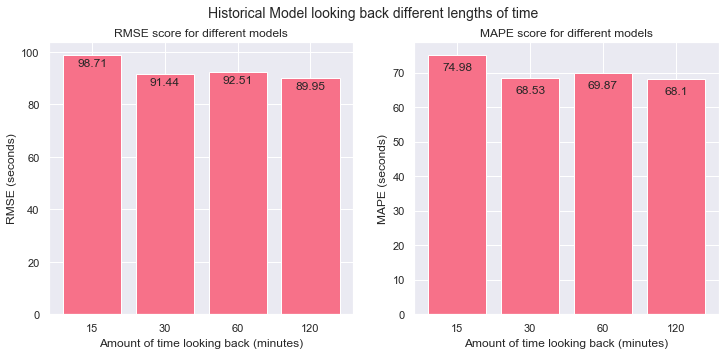

In [269]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

all_jrny_preds_52 = [preds_jrny_52_15m, preds_jrny_52_30m, preds_jrny_52_60m, preds_jrny_52_120m]
all_jrny_accs_52 = [accs_jrny_52_15m, accs_jrny_52_30m, accs_jrny_52_60m, accs_jrny_52_120m]

mapes_52m = []
rmses_52m = []

for i, time_back in enumerate(all_jrny_preds_52): 
    
    actual_seconds = [(a.total_seconds() * 60) for a in all_jrny_accs_52[i]]
    predicted_seconds = [p * 60 for p in time_back]

    mape52 = mean_absolute_error(actual_seconds, predicted_seconds)
    mse52 = mean_squared_error(actual_seconds, predicted_seconds)
    rmse52 = np.sqrt(mse52)

    mapes_52m.append(mape52)
    rmses_52m.append(rmse52)
    
time_back_labels = ["15", "30", "60", "120"]

fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].bar(time_back_labels, rmses_52m)
ax[0].set_title("RMSE score for different models")
ax[0].set_xlabel("Amount of time looking back (minutes)")
ax[0].set_ylabel("RMSE (seconds)")

rects_rmse = ax[0].patches
labels_rmsem = [round(rmses_52m[0], 2), round(rmses_52m[1], 2), round(rmses_52m[2], 2), round(rmses_52m[3], 2)]

for rect, label in zip(rects_rmse, labels_rmsem):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')
    
ax[1].bar(time_back_labels, mapes_52m)
ax[1].set_title("MAPE score for different models")
ax[1].set_xlabel("Amount of time looking back (minutes)")
ax[1].set_ylabel("MAPE (seconds)")

rects_mape = ax[1].patches
labels_mapem = [round(mapes_52m[0], 2), round(mapes_52m[1], 2), round(mapes_52m[2], 2), round(mapes_52m[3], 2)]

for rect, label in zip(rects_mape, labels_mapem):
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')

fig.suptitle('Historical Model looking back different lengths of time', fontsize=14)
plt.show()

### Look back different numbers of buses
1) 2 buses

2) 5 buses

3) 10 buses

4) 15 buses

In [314]:
def get_times_past_x_buses(stop_a, stop_b, a_id, req_time, buses_back):
    
    """
    journey_times 
        - is a list of journey times for the last buses_back number of buses arriving at 
        stop b 
    most_recent_left
        - is the last vehicle to leave stop a and arrive at stop b before req_time.
    arrived_journeys
        - is a list of bus details for vehicles arriving at stop b. 1st in the list is the
        most recent bus to have arrived, last in the list is the oldest bus to arrive.
    """

    journey_times = []
    left_indices = []
    arrived_journeys = []
    req_time = convert_time_to_datetime(req_time)
    count = 0
    
    # reverse direction of stop b entries.
    reversed_b = stop_b.sort_values(by='time_of_arrival', ascending=False, ignore_index=True)

    for i, journey in reversed_b.iterrows():
        arr_dt = convert_time_to_datetime(journey['time_of_arrival'])
        
        if arr_dt < req_time:
            # first one we encounter is the most recent arrived.
            
            [bus_id, b_id, date, direction, _] = journey['vehicle_id'].split('_')
            to_match_id = bus_id + '_' + a_id + '_' + date + '_' + direction + '_'
            
            for j, match in stop_a.iterrows():
                if match['vehicle_id'].startswith(to_match_id):
                    
                    # vehicle id matches
                    leave_dt = convert_time_to_datetime(match['time_of_arrival'])
                    journey_time = arr_dt - leave_dt

                    if (journey_time > dt.timedelta(minutes = 0)) & (journey_time < dt.timedelta(minutes = 15)):
                        # journey time is feasible as being the same journey
                            
                        left_indices.append(j)
                        arrived_journeys.append(journey)
                        journey_times.append(journey_time)
                        count = count + 1
                        break
            
        if count == buses_back:
            break
    
    most_recent_left = -1
    if len(left_indices) > 0:
        most_recent_left = left_indices[0]
    
    return most_recent_left, arrived_journeys, journey_times

In [315]:
def predict_journey_time_buses_back(req_time, stop_a, stop_b, a_id, buses_back):
    """
    - A request for the predicted journey time of a bus arriving at stop b is 
    made at req_time
    - Returns the predicted journey time based on journey times for the past x buses back
    - Journey times from the past time_back minutes are weighted depending on how many buses
    back we are looking.
    - most_recent_left is the the last bus that left stop a and arrived at stop be before
    req_time.

    """
    weights_2 = {"2": 1}
    weights_5 = {"2": 0.55, "5": 0.45}
    weights_10 = {"2": 0.55, "5": 0.35, "10": 0.1}
    weights_15 = {"2": 0.45, "5": 0.3, "10": 0.2, "15": 0.05}
    
    weights = weights_10
    
    most_recent_left_indx, arrived, journey_times = get_times_past_x_buses(stop_a, stop_b, a_id, req_time, buses_back)
    
    if buses_back == 2:
        weights = weights_2
    elif buses_back == 5:
        weights = weights_5
    elif buses_back == 15:
        weights = weights_15
    
    pred = 0
    sum_weights = 0
    for index, item in enumerate(arrived):
        weight = 0
        if (index < 2):
            weight = weights["2"]
        elif (index < 5) & (index >= 2):
            weight = weights["5"]
        elif (index < 10) & (index >= 5):
            weight = weights["10"]
        elif (index < 15) & (index >= 10):
            weight = weights["15"]

        journey_time = journey_times[index].total_seconds()
        pred += weight * journey_time
        sum_weights += weight
    
    if (sum_weights == 0) or (most_recent_left_indx == -1):
        return pred, most_recent_left_indx
    
    pred = pred / sum_weights
    
    return pred, most_recent_left_indx

In [255]:
# Getting predicted arrival times for buses on route 52 for a gap of 5 stops.
"""
preds_52 = predicted arrival times (datetime)
accs_52 = actual arrival times (datetime)
req_timesx_52 = request times that returned valid values
preds_jrny_52 = predicted journey times (float in minutes)
accs_jrny_52 = actual journey times (timedelta in minutes)
"""

req_times_52 = generate_request_times(30, "2020-05-03 02:00:00", "2020-05-08 23:59:59")

# looking at journeys for the past 2 buses
_, _, req_timesx_52_2b, preds_jrny_52_2b, accs_jrny_52_2b = eval_historical_model(0, 2, req_times_52, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

Request time is  2020-05-03 02:00:00
Predicted journey time is  4.316666666666666
There are no buses due at this time from this stop
Request time is  2020-05-03 02:30:00
Predicted journey time is  4.316666666666666
There are no buses due at this time from this stop
Request time is  2020-05-03 03:00:00
Predicted journey time is  4.2
There are no buses due at this time from this stop
Request time is  2020-05-03 03:30:00
Predicted journey time is  4.2
Actual journey time is 0:08:00
Request time is  2020-05-03 04:00:00
Predicted journey time is  3.15
There are no buses due at this time from this stop
Request time is  2020-05-03 04:30:00
Predicted journey time is  3.15
There are no buses due at this time from this stop
Request time is  2020-05-03 05:00:00
Predicted journey time is  4.416666666666667
There are no buses due at this time from this stop
Request time is  2020-05-03 05:30:00
Predicted journey time is  4.416666666666667
There are no buses due at this time from this stop
Request ti

Predicted journey time is  8.241666666666667
Actual journey time is 0:06:33
Request time is  2020-05-04 14:00:00
Predicted journey time is  5.95
There are no buses due at this time from this stop
Request time is  2020-05-04 14:30:00
Predicted journey time is  6.75
Actual journey time is 0:06:47
Request time is  2020-05-04 15:00:00
Predicted journey time is  7.708333333333333
There are no buses due at this time from this stop
Request time is  2020-05-04 15:30:00
Predicted journey time is  6.933333333333334
Actual journey time is 0:05:47
Request time is  2020-05-04 16:00:00
Predicted journey time is  6.558333333333334
There are no buses due at this time from this stop
Request time is  2020-05-04 16:30:00
Predicted journey time is  5.575
Request time is  2020-05-04 17:00:00
Predicted journey time is  6.458333333333333
Actual journey time is 0:06:51
Request time is  2020-05-04 17:30:00
Predicted journey time is  6.658333333333333
There are no buses due at this time from this stop
Request t

Predicted journey time is  4.883333333333334
There are no buses due at this time from this stop
Request time is  2020-05-06 03:30:00
Predicted journey time is  4.883333333333334
There are no buses due at this time from this stop
Request time is  2020-05-06 04:00:00
Predicted journey time is  4.208333333333333
There are no buses due at this time from this stop
Request time is  2020-05-06 04:30:00
Predicted journey time is  4.383333333333334
There are no buses due at this time from this stop
Request time is  2020-05-06 05:00:00
Predicted journey time is  4.075
There are no buses due at this time from this stop
Request time is  2020-05-06 05:30:00
Predicted journey time is  3.966666666666667
Actual journey time is 0:05:19
Request time is  2020-05-06 06:00:00
Predicted journey time is  6.108333333333333
Actual journey time is 0:05:52
Request time is  2020-05-06 06:30:00
Predicted journey time is  4.975
There are no buses due at this time from this stop
Request time is  2020-05-06 07:00:00


Predicted journey time is  5.208333333333333
Actual journey time is 0:07:11
Request time is  2020-05-07 16:00:00
Predicted journey time is  5.241666666666666
There are no buses due at this time from this stop
Request time is  2020-05-07 16:30:00
Predicted journey time is  6.1
Actual journey time is 0:06:41
Request time is  2020-05-07 17:00:00
Predicted journey time is  6.308333333333334
Request time is  2020-05-07 17:30:00
Predicted journey time is  6.308333333333334
Request time is  2020-05-07 18:00:00
Predicted journey time is  5.266666666666667
Actual journey time is 0:07:45
Request time is  2020-05-07 18:30:00
Predicted journey time is  6.591666666666667
There are no buses due at this time from this stop
Request time is  2020-05-07 19:00:00
Predicted journey time is  4.2
Actual journey time is 0:06:36
Request time is  2020-05-07 19:30:00
Predicted journey time is  5.758333333333334
There are no buses due at this time from this stop
Request time is  2020-05-07 20:00:00
Predicted jou

In [256]:
len(preds_jrny_52_2b)

83

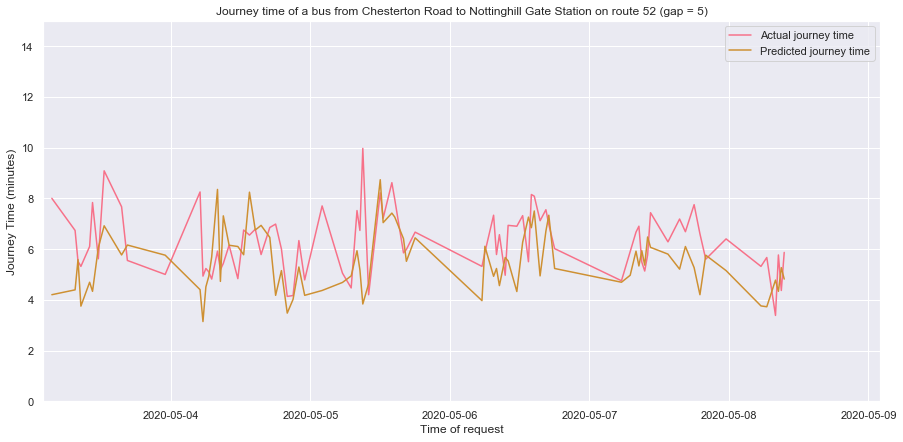

In [270]:
times_52_2b = [convert_time_to_datetime(t) for t in req_timesx_52_2b]
actual_jrny_52_2b = [x.total_seconds() for x in accs_jrny_52_2b]

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(times_52_2b, actual_jrny_52_2b, label="Actual journey time")
ax.plot(times_52_2b, preds_jrny_52_2b, label="Predicted journey time")
ax.set_xlabel("Time of request")
ax.set_ylabel("Journey Time (minutes)")
ax.set_ylim(0, 15)
ax.set_xlim([dt.datetime(2020, 5, 3, 2), dt.datetime(2020, 5, 9, 2)])
ax.set_title("Journey time of a bus from Chesterton Road to Nottinghill Gate Station on route 52 (gap = 5)")
ax.legend()

plt.show()

In [236]:
# looking at journeys in the past 5 buses
_, _, req_timesx_52_5b, preds_jrny_52_5b, accs_jrny_52_5b = eval_historical_model(0, 5, req_times_52, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

# looking at journeys in the past 10 buses
_, _, req_timesx_52_10b, preds_jrny_52_10b, accs_jrny_52_10b = eval_historical_model(0, 10, req_times_52, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

# looking at journeys in the past 15 buses
_, _, req_timesx_52_15b, preds_jrny_52_15b, accs_jrny_52_15b = eval_historical_model(0, 15, req_times_52, stop_a52, stop_b52, stop_a_id52, stop_b_id52)

Request time is  2020-05-03 02:00:00
Predicted journey time is  4.7115646258503405
There are no buses due at this time from this stop
Request time is  2020-05-03 02:30:00
Predicted journey time is  4.7115646258503405
There are no buses due at this time from this stop
Request time is  2020-05-03 03:00:00
Predicted journey time is  4.451020408163265
There are no buses due at this time from this stop
Request time is  2020-05-03 03:30:00
Predicted journey time is  4.451020408163265
Actual journey time is 0:08:00
Request time is  2020-05-03 04:00:00
Predicted journey time is  4.33469387755102
There are no buses due at this time from this stop
Request time is  2020-05-03 04:30:00
Predicted journey time is  4.33469387755102
There are no buses due at this time from this stop
Request time is  2020-05-03 05:00:00
Predicted journey time is  4.517687074829931
There are no buses due at this time from this stop
Request time is  2020-05-03 05:30:00
Predicted journey time is  3.9482993197278917
There 

Predicted journey time is  4.866326530612245
There are no buses due at this time from this stop
Request time is  2020-05-04 12:30:00
Predicted journey time is  4.885714285714286
Actual journey time is 0:06:45
Request time is  2020-05-04 13:00:00
Predicted journey time is  5.754421768707483
There are no buses due at this time from this stop
Request time is  2020-05-04 13:30:00
Predicted journey time is  7.468707482993198
Actual journey time is 0:06:33
Request time is  2020-05-04 14:00:00
Predicted journey time is  6.810204081632652
There are no buses due at this time from this stop
Request time is  2020-05-04 14:30:00
Predicted journey time is  6.327551020408163
Actual journey time is 0:06:47
Request time is  2020-05-04 15:00:00
Predicted journey time is  7.094557823129252
There are no buses due at this time from this stop
Request time is  2020-05-04 15:30:00
Predicted journey time is  7.098639455782313
Actual journey time is 0:05:47
Request time is  2020-05-04 16:00:00
Predicted journe

Request time is  2020-05-05 23:30:00
Predicted journey time is  5.975850340136054
Request time is  2020-05-06 00:00:00
Predicted journey time is  5.975850340136054
Request time is  2020-05-06 00:30:00
Predicted journey time is  5.975850340136054
Request time is  2020-05-06 01:00:00
Predicted journey time is  5.975850340136054
Request time is  2020-05-06 01:30:00
Predicted journey time is  5.975850340136054
Request time is  2020-05-06 02:00:00
Predicted journey time is  5.691496598639455
There are no buses due at this time from this stop
Request time is  2020-05-06 02:30:00
Predicted journey time is  5.691496598639455
There are no buses due at this time from this stop
Request time is  2020-05-06 03:00:00
Predicted journey time is  5.691496598639455
There are no buses due at this time from this stop
Request time is  2020-05-06 03:30:00
Predicted journey time is  5.691496598639455
There are no buses due at this time from this stop
Request time is  2020-05-06 04:00:00
Predicted journey tim

Predicted journey time is  6.278231292517007
There are no buses due at this time from this stop
Request time is  2020-05-07 11:30:00
Predicted journey time is  6.433333333333334
Request time is  2020-05-07 12:00:00
Predicted journey time is  6.690816326530612
There are no buses due at this time from this stop
Request time is  2020-05-07 12:30:00
Predicted journey time is  6.565306122448979
Request time is  2020-05-07 13:00:00
Predicted journey time is  6.530272108843537
There are no buses due at this time from this stop
Request time is  2020-05-07 13:30:00
Predicted journey time is  6.332653061224489
Actual journey time is 0:06:17
Request time is  2020-05-07 14:00:00
Predicted journey time is  6.489115646258504
There are no buses due at this time from this stop
Request time is  2020-05-07 14:30:00
Predicted journey time is  6.76734693877551
There are no buses due at this time from this stop
Request time is  2020-05-07 15:00:00
Predicted journey time is  7.237074829931973
There are no b

Predicted journey time is  5.146938775510204
There are no buses due at this time from this stop
Request time is  2020-05-08 21:30:00
Predicted journey time is  5.146938775510204
There are no buses due at this time from this stop
Request time is  2020-05-08 22:00:00
Predicted journey time is  5.146938775510204
There are no buses due at this time from this stop
Request time is  2020-05-08 22:30:00
Predicted journey time is  5.146938775510204
There are no buses due at this time from this stop
Request time is  2020-05-08 23:00:00
Predicted journey time is  5.146938775510204
There are no buses due at this time from this stop
Request time is  2020-05-08 23:30:00
Predicted journey time is  5.146938775510204
There are no buses due at this time from this stop
Request time is  2020-05-09 00:00:00
Predicted journey time is  5.146938775510204
There are no buses due at this time from this stop
Total time taken:  318.6761043071747
Request time is  2020-05-03 02:00:00
Predicted journey time is  4.922

Predicted journey time is  5.786163522012576
Actual journey time is 0:05:11
Request time is  2020-05-04 09:00:00
Predicted journey time is  6.082704402515722
Actual journey time is 0:05:26
Request time is  2020-05-04 09:30:00
Predicted journey time is  6.535534591194968
There are no buses due at this time from this stop
Request time is  2020-05-04 10:00:00
Predicted journey time is  6.244654088050313
Actual journey time is 0:06:09
Request time is  2020-05-04 10:30:00
Predicted journey time is  6.449056603773584
There are no buses due at this time from this stop
Request time is  2020-05-04 11:00:00
Predicted journey time is  6.46823899371069
There are no buses due at this time from this stop
Request time is  2020-05-04 11:30:00
Predicted journey time is  6.32452830188679
Actual journey time is 0:04:50
Request time is  2020-05-04 12:00:00
Predicted journey time is  5.1286163522012576
There are no buses due at this time from this stop
Request time is  2020-05-04 12:30:00
Predicted journey

Predicted journey time is  6.488364779874213
Request time is  2020-05-05 19:00:00
Predicted journey time is  6.488364779874213
Request time is  2020-05-05 19:30:00
Predicted journey time is  6.488364779874213
Request time is  2020-05-05 20:00:00
Predicted journey time is  6.488364779874213
Request time is  2020-05-05 20:30:00
Predicted journey time is  6.488364779874213
Request time is  2020-05-05 21:00:00
Predicted journey time is  5.931132075471696
There are no buses due at this time from this stop
Request time is  2020-05-05 21:30:00
Predicted journey time is  5.931132075471696
Request time is  2020-05-05 22:00:00
Predicted journey time is  5.931132075471696
Request time is  2020-05-05 22:30:00
Predicted journey time is  5.931132075471696
Request time is  2020-05-05 23:00:00
Predicted journey time is  5.931132075471696
Request time is  2020-05-05 23:30:00
Predicted journey time is  5.931132075471696
Request time is  2020-05-06 00:00:00
Predicted journey time is  5.931132075471696
Re

Predicted journey time is  5.105660377358489
There are no buses due at this time from this stop
Request time is  2020-05-07 08:00:00
Predicted journey time is  5.549999999999998
Actual journey time is 0:06:40
Request time is  2020-05-07 08:30:00
Predicted journey time is  5.589937106918238
Actual journey time is 0:06:54
Request time is  2020-05-07 09:00:00
Predicted journey time is  5.81383647798742
Actual journey time is 0:05:29
Request time is  2020-05-07 09:30:00
Predicted journey time is  5.722012578616352
Actual journey time is 0:05:08
Request time is  2020-05-07 10:00:00
Predicted journey time is  5.92012578616352
Actual journey time is 0:05:46
Request time is  2020-05-07 10:30:00
Predicted journey time is  5.926100628930815
Actual journey time is 0:07:26
Request time is  2020-05-07 11:00:00
Predicted journey time is  6.172327044025156
There are no buses due at this time from this stop
Request time is  2020-05-07 11:30:00
Predicted journey time is  6.364779874213835
Request time 

Predicted journey time is  5.1025157232704395
There are no buses due at this time from this stop
Request time is  2020-05-08 18:30:00
Predicted journey time is  5.1025157232704395
There are no buses due at this time from this stop
Request time is  2020-05-08 19:00:00
Predicted journey time is  5.1025157232704395
There are no buses due at this time from this stop
Request time is  2020-05-08 19:30:00
Predicted journey time is  5.1025157232704395
There are no buses due at this time from this stop
Request time is  2020-05-08 20:00:00
Predicted journey time is  5.1025157232704395
There are no buses due at this time from this stop
Request time is  2020-05-08 20:30:00
Predicted journey time is  5.1025157232704395
There are no buses due at this time from this stop
Request time is  2020-05-08 21:00:00
Predicted journey time is  5.1025157232704395
There are no buses due at this time from this stop
Request time is  2020-05-08 21:30:00
Predicted journey time is  5.1025157232704395
There are no bus

Predicted journey time is  4.800546448087431
Actual journey time is 0:08:15
Request time is  2020-05-04 05:30:00
Predicted journey time is  4.585245901639344
Actual journey time is 0:04:56
Request time is  2020-05-04 06:00:00
Predicted journey time is  4.590710382513661
Actual journey time is 0:05:14
Request time is  2020-05-04 06:30:00
Predicted journey time is  4.674863387978143
Actual journey time is 0:05:06
Request time is  2020-05-04 07:00:00
Predicted journey time is  4.878688524590163
Actual journey time is 0:04:49
Request time is  2020-05-04 07:30:00
Predicted journey time is  4.873497267759562
There are no buses due at this time from this stop
Request time is  2020-05-04 08:00:00
Predicted journey time is  5.838251366120218
Actual journey time is 0:05:55
Request time is  2020-05-04 08:30:00
Predicted journey time is  5.5404371584699454
Actual journey time is 0:05:11
Request time is  2020-05-04 09:00:00
Predicted journey time is  6.006284153005465
Actual journey time is 0:05:26

Predicted journey time is  6.954371584699456
There are no buses due at this time from this stop
Request time is  2020-05-05 16:00:00
Predicted journey time is  6.954371584699456
Actual journey time is 0:05:51
Request time is  2020-05-05 16:30:00
Predicted journey time is  6.333333333333335
Actual journey time is 0:05:59
Request time is  2020-05-05 17:00:00
Predicted journey time is  6.1467213114754085
There are no buses due at this time from this stop
Request time is  2020-05-05 17:30:00
Predicted journey time is  6.228415300546448
There are no buses due at this time from this stop
Request time is  2020-05-05 18:00:00
Predicted journey time is  6.2551912568306
Actual journey time is 0:06:40
Request time is  2020-05-05 18:30:00
Predicted journey time is  6.281420765027321
Request time is  2020-05-05 19:00:00
Predicted journey time is  6.281420765027321
Request time is  2020-05-05 19:30:00
Predicted journey time is  6.281420765027321
Request time is  2020-05-05 20:00:00
Predicted journey

Predicted journey time is  4.538797814207651
There are no buses due at this time from this stop
Request time is  2020-05-07 05:00:00
Predicted journey time is  4.316393442622951
There are no buses due at this time from this stop
Request time is  2020-05-07 05:30:00
Predicted journey time is  4.41912568306011
Actual journey time is 0:04:45
Request time is  2020-05-07 06:00:00
Predicted journey time is  4.528142076502732
There are no buses due at this time from this stop
Request time is  2020-05-07 06:30:00
Predicted journey time is  4.928142076502733
There are no buses due at this time from this stop
Request time is  2020-05-07 07:00:00
Predicted journey time is  4.977049180327869
Actual journey time is 0:05:54
Request time is  2020-05-07 07:30:00
Predicted journey time is  5.1
There are no buses due at this time from this stop
Request time is  2020-05-07 08:00:00
Predicted journey time is  5.44207650273224
Actual journey time is 0:06:40
Request time is  2020-05-07 08:30:00
Predicted jo

Predicted journey time is  4.978142076502732
There are no buses due at this time from this stop
Request time is  2020-05-08 15:30:00
Predicted journey time is  4.978142076502732
There are no buses due at this time from this stop
Request time is  2020-05-08 16:00:00
Predicted journey time is  4.978142076502732
There are no buses due at this time from this stop
Request time is  2020-05-08 16:30:00
Predicted journey time is  4.978142076502732
There are no buses due at this time from this stop
Request time is  2020-05-08 17:00:00
Predicted journey time is  4.978142076502732
There are no buses due at this time from this stop
Request time is  2020-05-08 17:30:00
Predicted journey time is  4.978142076502732
There are no buses due at this time from this stop
Request time is  2020-05-08 18:00:00
Predicted journey time is  4.978142076502732
There are no buses due at this time from this stop
Request time is  2020-05-08 18:30:00
Predicted journey time is  4.978142076502732
There are no buses due a

In [258]:
print(len(preds_jrny_52_5b), len(preds_jrny_52_10b), len(preds_jrny_52_15b))

83 83 83


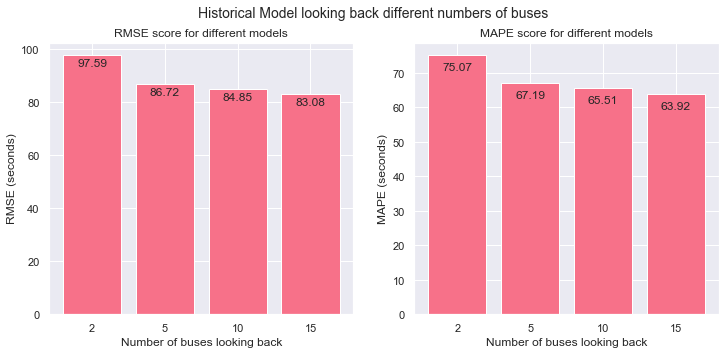

In [271]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

all_jrny_preds_52 = [preds_jrny_52_2b, preds_jrny_52_5b, preds_jrny_52_10b, preds_jrny_52_15b]
all_jrny_accs_52 = [accs_jrny_52_2b, accs_jrny_52_5b, accs_jrny_52_10b, accs_jrny_52_15b]

mapes_52b = []
rmses_52b = []

for i, buses_back in enumerate(all_jrny_preds_52): 
    
    actual_seconds = [(a.total_seconds() * 60) for a in all_jrny_accs_52[i]]
    predicted_seconds = [p * 60 for p in buses_back]

    mape52 = mean_absolute_error(actual_seconds, predicted_seconds)
    mse52 = mean_squared_error(actual_seconds, predicted_seconds)
    rmse52 = np.sqrt(mse52)

    mapes_52b.append(mape52)
    rmses_52b.append(rmse52)
    
buses_back_labels = ["2", "5", "10", "15"]

fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

ax[0].bar(buses_back_labels, rmses_52b)
ax[0].set_title("RMSE score for different models")
ax[0].set_xlabel("Number of buses looking back")
ax[0].set_ylabel("RMSE (seconds)")

rects_rmse = ax[0].patches
labels_rmseb = [round(rmses_52b[0], 2), round(rmses_52b[1], 2), round(rmses_52b[2], 2), round(rmses_52b[3], 2)]

for rect, label in zip(rects_rmse, labels_rmseb):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')
    
ax[1].bar(buses_back_labels, mapes_52b)
ax[1].set_title("MAPE score for different models")
ax[1].set_xlabel("Number of buses looking back")
ax[1].set_ylabel("MAPE (seconds)")

rects_mape = ax[1].patches
labels_mapeb = [round(mapes_52b[0], 2), round(mapes_52b[1], 2), round(mapes_52b[2], 2), round(mapes_52b[3], 2)]

for rect, label in zip(rects_mape, labels_mapeb):
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')

fig.suptitle('Historical Model looking back different numbers of buses', fontsize=14)
plt.show()

### Compare all 8 models against each other

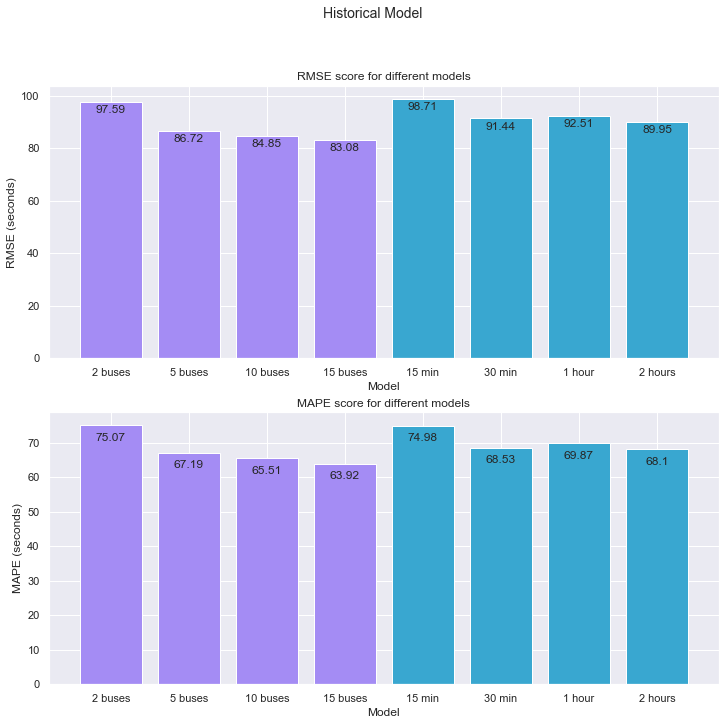

In [277]:
compare_labels = ["2 buses", "5 buses", "10 buses", "15 buses", "15 min", "30 min", "1 hour", "2 hours"]
rmses_compare = rmses_52b + rmses_52m
mapes_compare = mapes_52b + mapes_52m
colour_map = [cs[6], cs[6], cs[6], cs[6], cs[5], cs[5], cs[5], cs[5]]

fig, ax = plt.subplots(figsize=(12,11), nrows = 2, ncols = 1)

# different colours for buses back bersus time back
ax[0].bar(compare_labels, rmses_compare, color=colour_map)
ax[0].set_title("RMSE score for different models")
ax[0].set_xlabel("Model")
ax[0].set_ylabel("RMSE (seconds)")

rects_rmse = ax[0].patches
labels_rmse = labels_rmseb + labels_rmsem

for rect, label in zip(rects_rmse, labels_rmse):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')
    
ax[1].bar(compare_labels, mapes_compare, color=colour_map)
ax[1].set_title("MAPE score for different models")
ax[1].set_xlabel("Model")
ax[1].set_ylabel("MAPE (seconds)")

rects_mape = ax[1].patches
labels_mape = labels_mapeb + labels_mapem

for rect, label in zip(rects_mape, labels_mape):
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')

fig.suptitle('Historical Model', fontsize=14)
plt.show()

### Store values for global evaluation

In [266]:
historical_mapes = mapes_compare
historical_rmses = rmses_compare

%store historical_mapes historical_rmses

Stored 'historical_mapes' (list)
Stored 'historical_rmses' (list)


CONCLUSIONS: According to both the MAPE and RMSE, the best model is the model that looks back at the journey times of the last 15 buses.

### Different gaps for predictions for bus route 52

Test the best model (i.e. looking back 15 buses) on gaps of varying sizes (from gap of size 5 up to gap of size 30).

Then to make sure, test the 2nd, 3rd and 4th best models too i.e.

- looking back 10 buses
- looking back 5 buses
- looking back 120 minutes.

In [320]:
def get_actual_times_gap(arr_stop, req_time, bus_to_track, arr_stop_id, gap):
    """
    Params:
    - arr_stop: arrival stop = stop_b
    - req_time: time of request
    - bus_to_track: the bus that is being tracked to find its actual arrival time
    - arr_stop_id: stop b id
    - size of gap between stops
    
    Returns the arrival time and journey time (seconds) of the first bus that arrives 
    at arr_stop immediately after req_time.
    Returns -1, -1 if there is no bus that arrives after req_time.
    """
    
#     ['5 Okehampton Road', '10 Harrow Road / Kilburn Lane', '15 Chesterton Road', 
#      '20 Notting Hill Gate Station', '25 Palace Gate', 
#      '30 Knightsbridge Station  / Harrods', '35 Victoria Bus Station']
    
    # if gap == 5:
    min_time = 3
    max_time = 15
    
    if gap == 10:
        min_time = 10
        max_time = 22
    elif gap == 15:
        min_time = 15
        max_time = 30
    elif gap == 20:
        min_time = 20
        max_time = 40
    elif gap == 25:
        min_time = 31
        max_time = 55
    elif gap == 30:
        min_time = 40
        max_time = 70
    
    [bus_id, a_id, date, _, _] = bus_to_track['vehicle_id'].split('_')
    to_match_id = bus_id + '_' + arr_stop_id + '_' + date + '_'
    leave_time = convert_time_to_datetime(bus_to_track['time_of_arrival'])
    
    req_time = convert_time_to_datetime(req_time)
    for i, bus in arr_stop.iterrows():
        actual_arr_time = convert_time_to_datetime(bus['time_of_arrival'])
        
        if bus['vehicle_id'].startswith(to_match_id):
            
            if actual_arr_time > req_time:
                
                actual_jrny_time = actual_arr_time - leave_time + dt.timedelta(seconds = 30)
                
                if (actual_jrny_time > dt.timedelta(minutes = max_time)) or (actual_jrny_time < dt.timedelta(minutes = min_time)):
                    return -1, -1
                
                print("Actual journey time is {}".format(actual_jrny_time))
                return actual_arr_time, actual_jrny_time
        
    return -1, -1

In [321]:
def pred_eval_times_gap(req_time, stop_a, stop_b, a_id, b_id, buses_back, time_back, gap):
    """
    Use for testing and training
    
    If I request the arrival time of a bus at stop B at req_time, what is the predicted
    arrival time and journey time of the nearest bus?
    
    Returns the predicted and actual arrival time of a bus at stop B, as well as the
    predicted and actual journey time of a bus from stop A to stop B in seconds.
    
    If the actual bus data cannot be found, return 0s all around.
    
    """
    
    print("Request time is ", req_time)
    pred_jrny_time = 0
    if buses_back == -1:
        # option 1) look back x hours
        pred_jrny_time, most_recent_left = predict_journey_time_time_back(req_time, stop_a, stop_b, a_id, time_back)
    else:
        # option 2) look back x buses TODO
        pred_jrny_time, most_recent_left = predict_journey_time_buses_back(req_time, stop_a, stop_b, a_id, buses_back)
        
    print("Predicted journey time is ", (pred_jrny_time / 60))
    
    if pred_jrny_time == 0:
        # Can't find any journeys
        return 0, 0, 0, 0
    
    pred_arr, bus_to_track = predict_arrival_time(req_time, stop_a, pred_jrny_time, most_recent_left)
    
    if isinstance(bus_to_track, list):
        # Can't find correlating leaving bus
        return pred_arr, 0, 0, 0
    
    actual_arr, actual_jrny_time = get_actual_times_gap(stop_b, req_time, bus_to_track, b_id, gap)
    
    if actual_arr == -1:
        # There is no bus arriving at req_time
        return pred_arr, 0, 0, 0
    
    return pred_arr, actual_arr, pred_jrny_time, actual_jrny_time

In [322]:
print("Number of stops in route 52: ", len(stops_in_sequence_inbound.get("52")))
stop_a_gaps = stops_in_sequence_inbound.get("52")[1]

# Gap = 5
stop_b_5 = stops_in_sequence_inbound.get("52")[6]

# Gap = 10
stop_b_10 = stops_in_sequence_inbound.get("52")[11]

# Gap = 15
stop_b_15 = stops_in_sequence_inbound.get("52")[16]

# Gap = 20
stop_b_20 = stops_in_sequence_inbound.get("52")[21]

# Gap = 25
stop_b_25 = stops_in_sequence_inbound.get("52")[26]

# Gap = 30
stop_b_30 = stops_in_sequence_inbound.get("52")[31]

# Gap = 35
stop_b_35 = stops_in_sequence_inbound.get("52")[36]

destination_stops = [stop_b_5, stop_b_10, stop_b_15, stop_b_20, stop_b_25, stop_b_30, stop_b_35]
print("origin stop: ", stop_a_gaps)
print("destination stops: ", destination_stops)

Number of stops in route 52:  37
origin stop:  Willesden Bus Garage
destination stops:  ['Okehampton Road', 'Harrow Road / Kilburn Lane', 'Chesterton Road', 'Notting Hill Gate Station', 'Palace Gate', 'Knightsbridge Station  / Harrods', 'Victoria Bus Station']


In [323]:
stop_a_entries = b_52.loc[(b_52['bus_stop_name'] == stop_a_gaps) & (b_52['direction'] == 'inbound')]
[_, stop_a_id_gaps, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
print(stop_a_entries.shape)
print(stop_a_id_gaps)

(1208, 5)
490014687E


### Looking back 15 buses

In [313]:
"""
full_preds_varying_gaps = list of list of predicted journey times for different gap sizes
full_actual_varying_gaps = list of list of actual journey times for different gap sizes
full_req_varying_gaps = list of list of request times for different gap sizes.
"""

full_preds_varying_gaps = []
full_actual_varying_gaps = []
full_req_varying_gaps = []
req_times_52 = generate_request_times(30, "2020-05-03 02:00:00", "2020-05-08 23:59:59")

for i, end in enumerate(destination_stops):
    stop_b_entries = b_52.loc[(b_52['bus_stop_name'] == destination_stops[i]) & (b_52['direction'] == 'inbound')]
    [_, stop_b_id_gaps, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')
    
    preds_52 = []
    accs_52 = []
    req_timesx_52 = []
    
    gap = (i + 1) * 5

    for req_time in req_times_52:
        pt, at, pj, aj = pred_eval_times_gap(req_time, stop_a_entries, stop_b_entries, stop_a_id_gaps, stop_b_id_gaps, 15, 0, gap)
        if at == 0:
            continue
            
        req_timesx_52.append(req_time)
        preds_52.append(pj / 60)
        accs_52.append(aj / 60)
        
    full_preds_varying_gaps.append(preds_52)
    full_actual_varying_gaps.append(accs_52)
    full_req_varying_gaps.append(req_timesx_52)

Request time is  2020-05-03 02:00:00
Predicted journey time is  5.186612021857923
There are no buses due at this time from this stop
Request time is  2020-05-03 02:30:00
Predicted journey time is  5.186612021857923
There are no buses due at this time from this stop
Request time is  2020-05-03 03:00:00
Predicted journey time is  5.094808743169398
There are no buses due at this time from this stop
Request time is  2020-05-03 03:30:00
Predicted journey time is  5.0363387978142065
There are no buses due at this time from this stop
Request time is  2020-05-03 04:00:00
Predicted journey time is  5.018032786885246
There are no buses due at this time from this stop
Request time is  2020-05-03 04:30:00
Predicted journey time is  5.018032786885246
There are no buses due at this time from this stop
Request time is  2020-05-03 05:00:00
Predicted journey time is  5.025956284153006
There are no buses due at this time from this stop
Request time is  2020-05-03 05:30:00
Predicted journey time is  5.02

Predicted journey time is  6.326502732240437
Actual journey time is 0:05:32
Request time is  2020-05-04 11:30:00
Predicted journey time is  6.373224043715847
There are no buses due at this time from this stop
Request time is  2020-05-04 12:00:00
Predicted journey time is  6.490710382513663
Actual journey time is 0:07:46
Request time is  2020-05-04 12:30:00
Predicted journey time is  6.610655737704918
There are no buses due at this time from this stop
Request time is  2020-05-04 13:00:00
Predicted journey time is  6.753551912568309
Request time is  2020-05-04 13:30:00
Predicted journey time is  7.095355191256831
There are no buses due at this time from this stop
Request time is  2020-05-04 14:00:00
Predicted journey time is  7.201092896174864
Actual journey time is 0:07:42
Request time is  2020-05-04 14:30:00
Predicted journey time is  7.244808743169399
There are no buses due at this time from this stop
Request time is  2020-05-04 15:00:00
Predicted journey time is  7.457377049180327
Ac

Request time is  2020-05-05 21:30:00
Predicted journey time is  7.726775956284154
Request time is  2020-05-05 22:00:00
Predicted journey time is  7.726775956284154
Request time is  2020-05-05 22:30:00
Predicted journey time is  7.726775956284154
Request time is  2020-05-05 23:00:00
Predicted journey time is  7.726775956284154
Request time is  2020-05-05 23:30:00
Predicted journey time is  7.726775956284154
Request time is  2020-05-06 00:00:00
Predicted journey time is  7.726775956284154
Request time is  2020-05-06 00:30:00
Predicted journey time is  7.726775956284154
Request time is  2020-05-06 01:00:00
Predicted journey time is  7.726775956284154
Request time is  2020-05-06 01:30:00
Predicted journey time is  7.726775956284154
Request time is  2020-05-06 02:00:00
Predicted journey time is  7.726775956284154
Request time is  2020-05-06 02:30:00
Predicted journey time is  7.051912568306011
There are no buses due at this time from this stop
Request time is  2020-05-06 03:00:00
Predicted 

Predicted journey time is  5.696448087431696
There are no buses due at this time from this stop
Request time is  2020-05-07 11:00:00
Predicted journey time is  5.86311475409836
Actual journey time is 0:07:22
Request time is  2020-05-07 11:30:00
Predicted journey time is  5.915300546448088
There are no buses due at this time from this stop
Request time is  2020-05-07 12:00:00
Predicted journey time is  6.004371584699455
Actual journey time is 0:06:34
Request time is  2020-05-07 12:30:00
Predicted journey time is  6.480054644808744
There are no buses due at this time from this stop
Request time is  2020-05-07 13:00:00
Predicted journey time is  6.729234972677598
Actual journey time is 0:06:20
Request time is  2020-05-07 13:30:00
Predicted journey time is  6.723497267759563
There are no buses due at this time from this stop
Request time is  2020-05-07 14:00:00
Predicted journey time is  6.715027322404371
Actual journey time is 0:07:15
Request time is  2020-05-07 14:30:00
Predicted journey

Request time is  2020-05-08 23:30:00
Predicted journey time is  6.390710382513661
Request time is  2020-05-09 00:00:00
Predicted journey time is  6.390710382513661
Request time is  2020-05-03 02:00:00
Predicted journey time is  9.87950819672131
There are no buses due at this time from this stop
Request time is  2020-05-03 02:30:00
Predicted journey time is  9.87950819672131
There are no buses due at this time from this stop
Request time is  2020-05-03 03:00:00
Predicted journey time is  9.5724043715847
There are no buses due at this time from this stop
Request time is  2020-05-03 03:30:00
Predicted journey time is  9.196994535519126
There are no buses due at this time from this stop
Request time is  2020-05-03 04:00:00
Predicted journey time is  8.933333333333334
There are no buses due at this time from this stop
Request time is  2020-05-03 04:30:00
Predicted journey time is  8.933333333333334
There are no buses due at this time from this stop
Request time is  2020-05-03 05:00:00
Predi

Predicted journey time is  11.582513661202183
Actual journey time is 0:12:13
Request time is  2020-05-04 13:00:00
Predicted journey time is  11.696448087431696
Actual journey time is 0:12:32
Request time is  2020-05-04 13:30:00
Predicted journey time is  11.782513661202186
Actual journey time is 0:12:32
Request time is  2020-05-04 14:00:00
Predicted journey time is  12.168852459016394
Actual journey time is 0:10:59
Request time is  2020-05-04 14:30:00
Predicted journey time is  12.039071038251365
Actual journey time is 0:13:45
Request time is  2020-05-04 15:00:00
Predicted journey time is  12.405737704918034
Actual journey time is 0:13:23
Request time is  2020-05-04 15:30:00
Predicted journey time is  12.33032786885246
Actual journey time is 0:10:18
Request time is  2020-05-04 16:00:00
Predicted journey time is  12.379234972677597
Actual journey time is 0:12:46
Request time is  2020-05-04 16:30:00
Predicted journey time is  12.524316939890706
There are no buses due at this time from th

Predicted journey time is  10.46393442622951
There are no buses due at this time from this stop
Request time is  2020-05-06 01:00:00
Predicted journey time is  10.46393442622951
There are no buses due at this time from this stop
Request time is  2020-05-06 01:30:00
Predicted journey time is  10.46393442622951
There are no buses due at this time from this stop
Request time is  2020-05-06 02:00:00
Predicted journey time is  10.46393442622951
There are no buses due at this time from this stop
Request time is  2020-05-06 02:30:00
Predicted journey time is  10.090163934426233
There are no buses due at this time from this stop
Request time is  2020-05-06 03:00:00
Predicted journey time is  10.090163934426233
There are no buses due at this time from this stop
Request time is  2020-05-06 03:30:00
Predicted journey time is  10.090163934426233
There are no buses due at this time from this stop
Request time is  2020-05-06 04:00:00
Predicted journey time is  10.090163934426233
There are no buses d

Actual journey time is 0:11:10
Request time is  2020-05-07 13:30:00
Predicted journey time is  11.472677595628419
Actual journey time is 0:11:04
Request time is  2020-05-07 14:00:00
Predicted journey time is  11.267486338797815
Actual journey time is 0:12:19
Request time is  2020-05-07 14:30:00
Predicted journey time is  11.386612021857925
There are no buses due at this time from this stop
Request time is  2020-05-07 15:00:00
Predicted journey time is  11.424863387978146
Actual journey time is 0:12:15
Request time is  2020-05-07 15:30:00
Predicted journey time is  11.862841530054643
Actual journey time is 0:13:19
Request time is  2020-05-07 16:00:00
Predicted journey time is  12.121857923497268
Actual journey time is 0:12:29
Request time is  2020-05-07 16:30:00
Predicted journey time is  11.998360655737706
Actual journey time is 0:13:21
Request time is  2020-05-07 17:00:00
Predicted journey time is  12.103005464480875
Request time is  2020-05-07 17:30:00
Predicted journey time is  12.1

Predicted journey time is  12.341803278688527
Request time is  2020-05-03 06:00:00
Predicted journey time is  12.199726775956284
Request time is  2020-05-03 06:30:00
Predicted journey time is  12.199726775956284
Request time is  2020-05-03 07:00:00
Predicted journey time is  12.125956284153006
There are no buses due at this time from this stop
Request time is  2020-05-03 07:30:00
Predicted journey time is  12.113661202185794
Request time is  2020-05-03 08:00:00
Predicted journey time is  12.381967213114756
Request time is  2020-05-03 08:30:00
Predicted journey time is  12.600000000000001
Request time is  2020-05-03 09:00:00
Predicted journey time is  12.596448087431698
Request time is  2020-05-03 09:30:00
Predicted journey time is  12.665573770491807
There are no buses due at this time from this stop
Request time is  2020-05-03 10:00:00
Predicted journey time is  12.665573770491807
Actual journey time is 0:17:26
Request time is  2020-05-03 10:30:00
Predicted journey time is  12.6576502

Predicted journey time is  11.952732240437161
There are no buses due at this time from this stop
Request time is  2020-05-05 01:30:00
Predicted journey time is  11.877049180327871
There are no buses due at this time from this stop
Request time is  2020-05-05 02:00:00
Predicted journey time is  11.840437158469946
There are no buses due at this time from this stop
Request time is  2020-05-05 02:30:00
Predicted journey time is  11.960928961748637
There are no buses due at this time from this stop
Request time is  2020-05-05 03:00:00
Predicted journey time is  11.773497267759565
There are no buses due at this time from this stop
Request time is  2020-05-05 03:30:00
Predicted journey time is  11.630327868852458
There are no buses due at this time from this stop
Request time is  2020-05-05 04:00:00
Predicted journey time is  11.599180327868854
There are no buses due at this time from this stop
Request time is  2020-05-05 04:30:00
Predicted journey time is  11.646174863387976
There are no bus

Request time is  2020-05-06 22:30:00
Predicted journey time is  12.728688524590165
Request time is  2020-05-06 23:00:00
Predicted journey time is  12.728688524590165
Request time is  2020-05-06 23:30:00
Predicted journey time is  12.728688524590165
Request time is  2020-05-07 00:00:00
Predicted journey time is  12.728688524590165
Request time is  2020-05-07 00:30:00
Predicted journey time is  12.728688524590165
Request time is  2020-05-07 01:00:00
Predicted journey time is  12.728688524590165
Request time is  2020-05-07 01:30:00
Predicted journey time is  12.53879781420765
There are no buses due at this time from this stop
Request time is  2020-05-07 02:00:00
Predicted journey time is  12.53879781420765
There are no buses due at this time from this stop
Request time is  2020-05-07 02:30:00
Predicted journey time is  12.53879781420765
There are no buses due at this time from this stop
Request time is  2020-05-07 03:00:00
Predicted journey time is  12.119945355191259
There are no buses d

Request time is  2020-05-08 20:00:00
Predicted journey time is  13.47103825136612
Request time is  2020-05-08 20:30:00
Predicted journey time is  13.47103825136612
Request time is  2020-05-08 21:00:00
Predicted journey time is  13.47103825136612
Request time is  2020-05-08 21:30:00
Predicted journey time is  13.47103825136612
Request time is  2020-05-08 22:00:00
Predicted journey time is  13.47103825136612
Request time is  2020-05-08 22:30:00
Predicted journey time is  13.47103825136612
Request time is  2020-05-08 23:00:00
Predicted journey time is  13.47103825136612
Request time is  2020-05-08 23:30:00
Predicted journey time is  13.47103825136612
Request time is  2020-05-09 00:00:00
Predicted journey time is  13.47103825136612
Request time is  2020-05-03 02:00:00
Predicted journey time is  14.032513661202188
There are no buses due at this time from this stop
Request time is  2020-05-03 02:30:00
Predicted journey time is  14.032513661202188
There are no buses due at this time from this

Predicted journey time is  12.795081967213116
Request time is  2020-05-04 22:30:00
Predicted journey time is  12.78032786885246
Actual journey time is 0:20:11
Request time is  2020-05-04 23:00:00
Predicted journey time is  13.306010928961747
Request time is  2020-05-04 23:30:00
Predicted journey time is  13.306010928961747
Request time is  2020-05-05 00:00:00
Predicted journey time is  13.306010928961747
Request time is  2020-05-05 00:30:00
Predicted journey time is  13.306010928961747
Request time is  2020-05-05 01:00:00
Predicted journey time is  13.306010928961747
Request time is  2020-05-05 01:30:00
Predicted journey time is  13.306010928961747
Request time is  2020-05-05 02:00:00
Predicted journey time is  13.306010928961747
Request time is  2020-05-05 02:30:00
Predicted journey time is  13.306010928961747
Request time is  2020-05-05 03:00:00
Predicted journey time is  13.306010928961747
Request time is  2020-05-05 03:30:00
Predicted journey time is  13.306010928961747
Request tim

Predicted journey time is  13.503825136612024
Request time is  2020-05-06 23:30:00
Predicted journey time is  13.503825136612024
Request time is  2020-05-07 00:00:00
Predicted journey time is  13.503825136612024
Request time is  2020-05-07 00:30:00
Predicted journey time is  13.503825136612024
Request time is  2020-05-07 01:00:00
Predicted journey time is  13.503825136612024
Request time is  2020-05-07 01:30:00
Predicted journey time is  13.503825136612024
Request time is  2020-05-07 02:00:00
Predicted journey time is  13.503825136612024
Request time is  2020-05-07 02:30:00
Predicted journey time is  13.503825136612024
Request time is  2020-05-07 03:00:00
Predicted journey time is  13.402732240437158
There are no buses due at this time from this stop
Request time is  2020-05-07 03:30:00
Predicted journey time is  13.402732240437158
Request time is  2020-05-07 04:00:00
Predicted journey time is  13.402732240437158
Request time is  2020-05-07 04:30:00
Predicted journey time is  13.608743

Request time is  2020-05-09 00:00:00
Predicted journey time is  12.456830601092898
Request time is  2020-05-03 02:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 02:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 03:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 03:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 04:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 04:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 05:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 05:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 06:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 06:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 07:00:00
Predicted journey time is  6.133333333333334
Request time is

Predicted journey time is  6.133333333333334
Request time is  2020-05-05 04:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 04:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 05:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 05:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 06:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 06:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 07:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 07:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 08:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 08:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 09:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 09:30:00
Predicted journe

Predicted journey time is  6.133333333333334
Request time is  2020-05-07 06:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 06:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 07:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 07:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 08:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 08:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 09:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 09:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 10:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 10:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 11:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 11:30:00
Predicted journe

IndexError: list index out of range

67


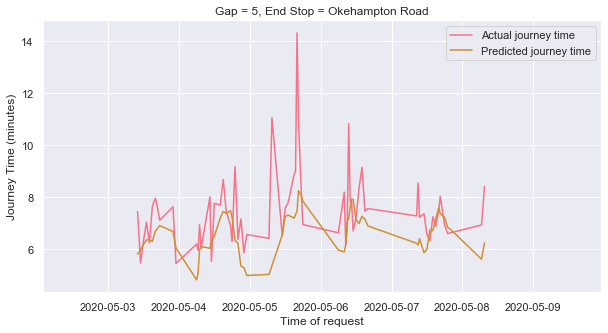

112


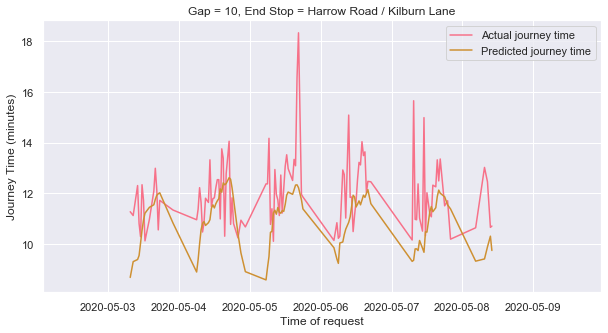

25


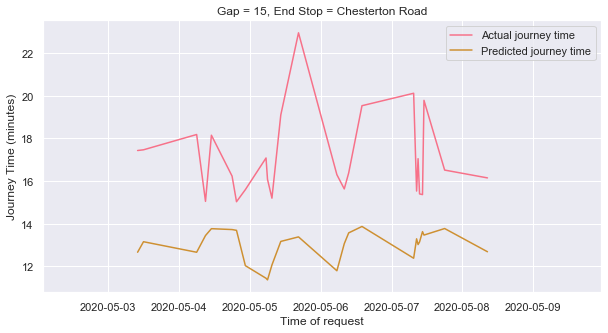

2


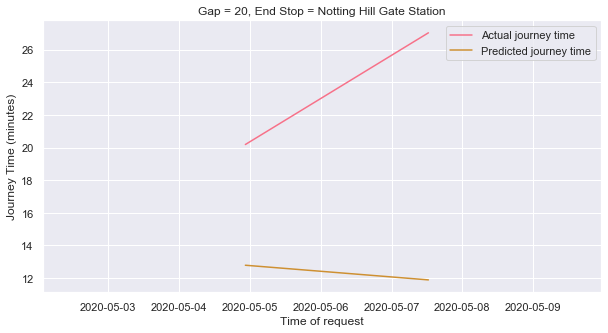

0


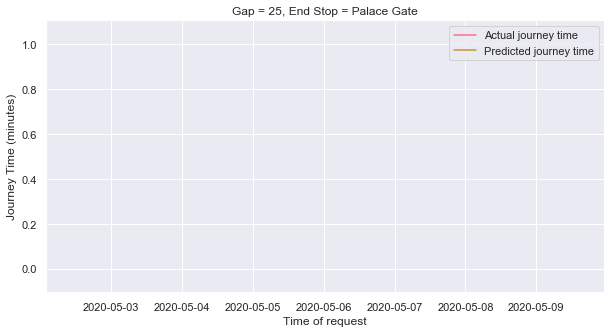

IndexError: list index out of range

In [316]:
for i, gap in enumerate(destination_stops):
    p = full_preds_varying_gaps[i]
    a = [x.total_seconds() for x in full_actual_varying_gaps[i]]
    t = full_req_varying_gaps[i]
    r = [convert_time_to_datetime(x) for x in t]
    print(len(p))
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(r, a, label="Actual journey time")
    ax.plot(r, p, label="Predicted journey time")
    ax.set_xlabel("Time of request")
    ax.set_ylabel("Journey Time (minutes)")
    ax.set_xlim([dt.datetime(2020, 5, 2, 2), dt.datetime(2020, 5, 9, 22, 59, 59)])
    ax.set_title("Gap = {}, End Stop = {}".format((i + 1) * 5, destination_stops[i]))
    ax.legend()
    plt.show()

In [318]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mapes_gaps_15b = []
rmses_gaps_15b = []

for i, gap in enumerate(destination_stops):
    p = full_preds_varying_gaps[i]
    a = full_actual_varying_gaps[i]
    t = full_req_varying_gaps[i]
    
    actual_seconds = [(x.total_seconds() * 60) for x in a]
    predicted_seconds = [x * 60 for x in p]

    mape = mean_absolute_error(actual_seconds, predicted_seconds)
    mse = mean_squared_error(actual_seconds, predicted_seconds)
    rmse = np.sqrt(mse)
    
    mapes_gaps_15b.append(mape)
    rmses_gaps_15b.append(rmse)

    print("Gap = {} MAPE = {}, RMSE = {}".format((i + 1) * 5, mape, rmse))

Gap = 5 MAPE = 65.48201823831658, RMSE = 97.26284217460861
Gap = 10 MAPE = 78.9199350614754, RMSE = 107.78118621990313
Gap = 15 MAPE = 247.2026173508196, RMSE = 273.6241499888124
Gap = 20 MAPE = 676.6557177049181, RMSE = 715.4773067548715


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
fig, ax = plt.subplots(figsize=(12,5), nrows = 1, ncols = 2)

gap_labels = []
ax[0].bar(gap_labels, rmses_gaps_15b)
ax[0].set_title("RMSE score for increasing gap size")
ax[0].set_xlabel("Gap size")
ax[0].set_ylabel("RMSE (seconds)")

rects_rmse = ax[0].patches
labels_rmseb = [round(rmses_gaps_15b[0], 2), round(rmses_gaps_15b[1], 2), round(rmses_gaps_15b[2], 2), round(rmses_gaps_15b[3], 2)]

for rect, label in zip(rects_rmse, labels_rmseb):
    height = rect.get_height()
    ax[0].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')
    
ax[1].bar(gap_labels, mapes_gaps_15b)
ax[1].set_title("MAPE score for increasing gap size")
ax[1].set_xlabel("Number of buses looking back")
ax[1].set_ylabel("MAPE (seconds)")

rects_mape = ax[1].patches
labels_mapeb = [round(mapes_gaps_15b[0], 2), round(mapes_gaps_15b[1], 2), round(mapes_gaps_15b[2], 2), round(mapes_gaps_15b[3], 2)]

for rect, label in zip(rects_mape, labels_mapeb):
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width() / 2, height - 5, label,
            ha='center', va='bottom')

fig.suptitle('Historical Model looking back at the last 15 buses', fontsize=14)
plt.show()

### Looking back 10 buses

In [ ]:
"""
full_preds_varying_gaps = list of list of predicted journey times for different gap sizes
full_actual_varying_gaps = list of list of actual journey times for different gap sizes
full_req_varying_gaps = list of list of request times for different gap sizes.
"""

full_preds_varying_gaps_10b = []
full_actual_varying_gaps_10b = []
full_req_varying_gaps_10b = []

for i, end in enumerate(destination_stops):
    stop_b_entries = b_52.loc[(b_52['bus_stop_name'] == destination_stops[i]) & (b_52['direction'] == 'inbound')]
    [_, stop_b_id_gaps, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')
    
    preds_52 = []
    accs_52 = []
    req_timesx_52 = []
    
    gap = (i + 1) * 5

    for req_time in req_times_52:
        pt, at, pj, aj = pred_eval_times_gap(req_time, stop_a_entries, stop_b_entries, stop_a_id_gaps, stop_b_id_gaps, 10, 0, gap)
        if at == 0:
            continue
            
        req_timesx_52.append(req_time)
        preds_52.append(pj / 60)
        accs_52.append(aj / 60)
        
    full_preds_varying_gaps_10b.append(preds_52)
    full_actual_varying_gaps_10b.append(accs_52)
    full_req_varying_gaps_10b.append(req_timesx_52)

Request time is  2020-05-03 02:00:00
Predicted journey time is  4.794654088050313
There are no buses due at this time from this stop
Request time is  2020-05-03 02:30:00
Predicted journey time is  4.794654088050313
There are no buses due at this time from this stop
Request time is  2020-05-03 03:00:00
Predicted journey time is  4.749999999999999
There are no buses due at this time from this stop
Request time is  2020-05-03 03:30:00
Predicted journey time is  4.729559748427673
There are no buses due at this time from this stop
Request time is  2020-05-03 04:00:00
Predicted journey time is  4.769496855345911
There are no buses due at this time from this stop
Request time is  2020-05-03 04:30:00
Predicted journey time is  4.769496855345911
There are no buses due at this time from this stop
Request time is  2020-05-03 05:00:00
Predicted journey time is  5.02704402515723
There are no buses due at this time from this stop
Request time is  2020-05-03 05:30:00
Predicted journey time is  5.0270

Actual journey time is 0:08:01
Request time is  2020-05-04 11:00:00
Predicted journey time is  6.3877358490566
Actual journey time is 0:05:32
Request time is  2020-05-04 11:30:00
Predicted journey time is  6.3911949685534575
There are no buses due at this time from this stop
Request time is  2020-05-04 12:00:00
Predicted journey time is  6.5377358490566015
Actual journey time is 0:07:46
Request time is  2020-05-04 12:30:00
Predicted journey time is  6.707861635220125
There are no buses due at this time from this stop
Request time is  2020-05-04 13:00:00
Predicted journey time is  6.907232704402514
Request time is  2020-05-04 13:30:00
Predicted journey time is  7.243710691823897
There are no buses due at this time from this stop
Request time is  2020-05-04 14:00:00
Predicted journey time is  7.335849056603772
Actual journey time is 0:07:42
Request time is  2020-05-04 14:30:00
Predicted journey time is  7.2575471698113185
There are no buses due at this time from this stop
Request time is

Request time is  2020-05-05 21:00:00
Predicted journey time is  7.455974842767293
Request time is  2020-05-05 21:30:00
Predicted journey time is  7.455974842767293
Request time is  2020-05-05 22:00:00
Predicted journey time is  7.455974842767293
Request time is  2020-05-05 22:30:00
Predicted journey time is  7.455974842767293
Request time is  2020-05-05 23:00:00
Predicted journey time is  7.455974842767293
Request time is  2020-05-05 23:30:00
Predicted journey time is  7.455974842767293
Request time is  2020-05-06 00:00:00
Predicted journey time is  7.455974842767293
Request time is  2020-05-06 00:30:00
Predicted journey time is  7.455974842767293
Request time is  2020-05-06 01:00:00
Predicted journey time is  7.455974842767293
Request time is  2020-05-06 01:30:00
Predicted journey time is  7.455974842767293
Request time is  2020-05-06 02:00:00
Predicted journey time is  7.455974842767293
Request time is  2020-05-06 02:30:00
Predicted journey time is  6.722012578616352
There are no bus

Predicted journey time is  5.898427672955973
There are no buses due at this time from this stop
Request time is  2020-05-07 10:30:00
Predicted journey time is  5.422955974842766
There are no buses due at this time from this stop
Request time is  2020-05-07 11:00:00
Predicted journey time is  5.76698113207547
Actual journey time is 0:07:22
Request time is  2020-05-07 11:30:00
Predicted journey time is  5.955974842767294
There are no buses due at this time from this stop
Request time is  2020-05-07 12:00:00
Predicted journey time is  6.186163522012577
Actual journey time is 0:06:34
Request time is  2020-05-07 12:30:00
Predicted journey time is  6.705974842767294
There are no buses due at this time from this stop
Request time is  2020-05-07 13:00:00
Predicted journey time is  6.986477987421383
Actual journey time is 0:06:20
Request time is  2020-05-07 13:30:00
Predicted journey time is  6.801572327044022
There are no buses due at this time from this stop
Request time is  2020-05-07 14:00:

Request time is  2020-05-08 22:30:00
Predicted journey time is  6.356918238993709
Request time is  2020-05-08 23:00:00
Predicted journey time is  6.356918238993709
Request time is  2020-05-08 23:30:00
Predicted journey time is  6.356918238993709
Request time is  2020-05-09 00:00:00
Predicted journey time is  6.356918238993709
Request time is  2020-05-03 02:00:00
Predicted journey time is  9.121698113207543
There are no buses due at this time from this stop
Request time is  2020-05-03 02:30:00
Predicted journey time is  9.121698113207543
There are no buses due at this time from this stop
Request time is  2020-05-03 03:00:00
Predicted journey time is  8.817610062893078
There are no buses due at this time from this stop
Request time is  2020-05-03 03:30:00
Predicted journey time is  8.421698113207544
There are no buses due at this time from this stop
Request time is  2020-05-03 04:00:00
Predicted journey time is  8.243396226415092
There are no buses due at this time from this stop
Request

Predicted journey time is  11.770440251572326
Actual journey time is 0:11:47
Request time is  2020-05-04 12:00:00
Predicted journey time is  11.362578616352199
Actual journey time is 0:11:49
Request time is  2020-05-04 12:30:00
Predicted journey time is  11.558805031446537
Actual journey time is 0:12:13
Request time is  2020-05-04 13:00:00
Predicted journey time is  11.771698113207544
Actual journey time is 0:12:32
Request time is  2020-05-04 13:30:00
Predicted journey time is  11.874842767295595
Actual journey time is 0:12:32
Request time is  2020-05-04 14:00:00
Predicted journey time is  12.347484276729555
Actual journey time is 0:10:59
Request time is  2020-05-04 14:30:00
Predicted journey time is  12.129874213836475
Actual journey time is 0:13:45
Request time is  2020-05-04 15:00:00
Predicted journey time is  12.476100628930816
Actual journey time is 0:13:23
Request time is  2020-05-04 15:30:00
Predicted journey time is  12.384591194968552
Actual journey time is 0:10:18
Request tim

Predicted journey time is  10.087106918238991
There are no buses due at this time from this stop
Request time is  2020-05-06 00:00:00
Predicted journey time is  10.087106918238991
There are no buses due at this time from this stop
Request time is  2020-05-06 00:30:00
Predicted journey time is  10.087106918238991
There are no buses due at this time from this stop
Request time is  2020-05-06 01:00:00
Predicted journey time is  10.087106918238991
There are no buses due at this time from this stop
Request time is  2020-05-06 01:30:00
Predicted journey time is  10.087106918238991
There are no buses due at this time from this stop
Request time is  2020-05-06 02:00:00
Predicted journey time is  10.087106918238991
There are no buses due at this time from this stop
Request time is  2020-05-06 02:30:00
Predicted journey time is  9.600628930817606
There are no buses due at this time from this stop
Request time is  2020-05-06 03:00:00
Predicted journey time is  9.600628930817606
There are no buses

Predicted journey time is  10.80471698113207
Actual journey time is 0:12:01
Request time is  2020-05-07 12:30:00
Predicted journey time is  10.796540880503143
There are no buses due at this time from this stop
Request time is  2020-05-07 13:00:00
Predicted journey time is  11.544025157232701
Actual journey time is 0:11:10
Request time is  2020-05-07 13:30:00
Predicted journey time is  11.921698113207544
Actual journey time is 0:11:04
Request time is  2020-05-07 14:00:00
Predicted journey time is  11.20220125786163
Actual journey time is 0:12:19
Request time is  2020-05-07 14:30:00
Predicted journey time is  11.271698113207545
There are no buses due at this time from this stop
Request time is  2020-05-07 15:00:00
Predicted journey time is  11.493710691823896
Actual journey time is 0:12:15
Request time is  2020-05-07 15:30:00
Predicted journey time is  12.038050314465409
Actual journey time is 0:13:19
Request time is  2020-05-07 16:00:00
Predicted journey time is  12.402515723270437
Actu

Predicted journey time is  11.680503144654086
There are no buses due at this time from this stop
Request time is  2020-05-03 05:00:00
Predicted journey time is  12.17578616352201
Request time is  2020-05-03 05:30:00
Predicted journey time is  12.228616352201254
Request time is  2020-05-03 06:00:00
Predicted journey time is  12.27578616352201
Request time is  2020-05-03 06:30:00
Predicted journey time is  12.27578616352201
Request time is  2020-05-03 07:00:00
Predicted journey time is  12.14905660377358
There are no buses due at this time from this stop
Request time is  2020-05-03 07:30:00
Predicted journey time is  12.115094339622637
Request time is  2020-05-03 08:00:00
Predicted journey time is  12.423270440251567
Request time is  2020-05-03 08:30:00
Predicted journey time is  12.787421383647795
Request time is  2020-05-03 09:00:00
Predicted journey time is  12.714465408805024
Request time is  2020-05-03 09:30:00
Predicted journey time is  12.68081761006289
There are no buses due at t

Predicted journey time is  11.927987421383646
There are no buses due at this time from this stop
Request time is  2020-05-05 00:30:00
Predicted journey time is  11.927987421383646
There are no buses due at this time from this stop
Request time is  2020-05-05 01:00:00
Predicted journey time is  11.852830188679242
There are no buses due at this time from this stop
Request time is  2020-05-05 01:30:00
Predicted journey time is  11.84088050314465
There are no buses due at this time from this stop
Request time is  2020-05-05 02:00:00
Predicted journey time is  11.940566037735845
There are no buses due at this time from this stop
Request time is  2020-05-05 02:30:00
Predicted journey time is  11.863522012578613
There are no buses due at this time from this stop
Request time is  2020-05-05 03:00:00
Predicted journey time is  11.662893081761002
There are no buses due at this time from this stop
Request time is  2020-05-05 03:30:00
Predicted journey time is  11.5003144654088
There are no buses 

Predicted journey time is  12.939937106918233
Request time is  2020-05-06 21:00:00
Predicted journey time is  12.939937106918233
Request time is  2020-05-06 21:30:00
Predicted journey time is  12.509433962264147
Request time is  2020-05-06 22:00:00
Predicted journey time is  12.55220125786163
Request time is  2020-05-06 22:30:00
Predicted journey time is  12.594968553459116
Request time is  2020-05-06 23:00:00
Predicted journey time is  12.594968553459116
Request time is  2020-05-06 23:30:00
Predicted journey time is  12.594968553459116
Request time is  2020-05-07 00:00:00
Predicted journey time is  12.594968553459116
Request time is  2020-05-07 00:30:00
Predicted journey time is  12.594968553459116
Request time is  2020-05-07 01:00:00
Predicted journey time is  12.594968553459116
Request time is  2020-05-07 01:30:00
Predicted journey time is  12.328616352201255
There are no buses due at this time from this stop
Request time is  2020-05-07 02:00:00
Predicted journey time is  12.3286163

Request time is  2020-05-08 18:00:00
Predicted journey time is  13.611949685534588
Request time is  2020-05-08 18:30:00
Predicted journey time is  13.611949685534588
Request time is  2020-05-08 19:00:00
Predicted journey time is  13.611949685534588
Request time is  2020-05-08 19:30:00
Predicted journey time is  13.611949685534588
Request time is  2020-05-08 20:00:00
Predicted journey time is  13.611949685534588
Request time is  2020-05-08 20:30:00
Predicted journey time is  13.611949685534588
Request time is  2020-05-08 21:00:00
Predicted journey time is  13.611949685534588
Request time is  2020-05-08 21:30:00
Predicted journey time is  13.611949685534588
Request time is  2020-05-08 22:00:00
Predicted journey time is  13.611949685534588
Request time is  2020-05-08 22:30:00
Predicted journey time is  13.611949685534588
Request time is  2020-05-08 23:00:00
Predicted journey time is  13.611949685534588
Request time is  2020-05-08 23:30:00
Predicted journey time is  13.611949685534588
Requ

Request time is  2020-05-04 20:00:00
Predicted journey time is  14.028616352201254
Request time is  2020-05-04 20:30:00
Predicted journey time is  12.272955974842764
Request time is  2020-05-04 21:00:00
Predicted journey time is  12.272955974842764
Request time is  2020-05-04 21:30:00
Predicted journey time is  12.272955974842764
Request time is  2020-05-04 22:00:00
Predicted journey time is  12.272955974842764
Request time is  2020-05-04 22:30:00
Predicted journey time is  12.242138364779871
Actual journey time is 0:20:11
Request time is  2020-05-04 23:00:00
Predicted journey time is  13.045283018867924
Request time is  2020-05-04 23:30:00
Predicted journey time is  13.045283018867924
Request time is  2020-05-05 00:00:00
Predicted journey time is  13.045283018867924
Request time is  2020-05-05 00:30:00
Predicted journey time is  13.045283018867924
Request time is  2020-05-05 01:00:00
Predicted journey time is  13.045283018867924
Request time is  2020-05-05 01:30:00
Predicted journey t

Predicted journey time is  13.71194968553459
Request time is  2020-05-06 21:30:00
Predicted journey time is  13.71194968553459
Request time is  2020-05-06 22:00:00
Predicted journey time is  13.71194968553459
Request time is  2020-05-06 22:30:00
Predicted journey time is  13.71194968553459
Request time is  2020-05-06 23:00:00
Predicted journey time is  13.71194968553459
Request time is  2020-05-06 23:30:00
Predicted journey time is  13.71194968553459
Request time is  2020-05-07 00:00:00
Predicted journey time is  13.71194968553459
Request time is  2020-05-07 00:30:00
Predicted journey time is  13.71194968553459
Request time is  2020-05-07 01:00:00
Predicted journey time is  13.71194968553459
Request time is  2020-05-07 01:30:00
Predicted journey time is  13.71194968553459
Request time is  2020-05-07 02:00:00
Predicted journey time is  13.71194968553459
Request time is  2020-05-07 02:30:00
Predicted journey time is  13.71194968553459
Request time is  2020-05-07 03:00:00
Predicted journe

Request time is  2020-05-08 22:00:00
Predicted journey time is  12.167924528301885
Request time is  2020-05-08 22:30:00
Predicted journey time is  12.167924528301885
Request time is  2020-05-08 23:00:00
Predicted journey time is  12.167924528301885
Request time is  2020-05-08 23:30:00
Predicted journey time is  12.167924528301885
Request time is  2020-05-09 00:00:00
Predicted journey time is  12.167924528301885
Request time is  2020-05-03 02:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 02:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 03:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 03:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 04:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 04:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-03 05:00:00
Predicted journey time is  6.133333333333334
Request tim

Predicted journey time is  6.133333333333334
Request time is  2020-05-05 02:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 02:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 03:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 03:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 04:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 04:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 05:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 05:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 06:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 06:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 07:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-05 07:30:00
Predicted journe

Predicted journey time is  6.133333333333334
Request time is  2020-05-07 04:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 04:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 05:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 05:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 06:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 06:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 07:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 07:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 08:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 08:30:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 09:00:00
Predicted journey time is  6.133333333333334
Request time is  2020-05-07 09:30:00
Predicted journe

### Looking back 5 buses

In [ ]:
"""
full_preds_varying_gaps = list of list of predicted journey times for different gap sizes
full_actual_varying_gaps = list of list of actual journey times for different gap sizes
full_req_varying_gaps = list of list of request times for different gap sizes.
"""

full_preds_varying_gaps_5b = []
full_actual_varying_gaps_5b = []
full_req_varying_gaps_5b = []

for i, end in enumerate(destination_stops):
    stop_b_entries = b_52.loc[(b_52['bus_stop_name'] == destination_stops[i]) & (b_52['direction'] == 'inbound')]
    [_, stop_b_id_gaps, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')
    
    preds_52 = []
    accs_52 = []
    req_timesx_52 = []
    
    gap = (i + 1) * 5

    for req_time in req_times_52:
        pt, at, pj, aj = pred_eval_times_gap(req_time, stop_a_entries, stop_b_entries, stop_a_id_gaps, stop_b_id_gaps, 5, 0, gap)
        if at == 0:
            continue
            
        req_timesx_52.append(req_time)
        preds_52.append(pj / 60)
        accs_52.append(aj / 60)
        
    full_preds_varying_gaps_5b.append(preds_52)
    full_actual_varying_gaps_5b.append(accs_52)
    full_req_varying_gaps_5b.append(req_timesx_52)

### Looking back 120 minutes

In [ ]:
"""
full_preds_varying_gaps = list of list of predicted journey times for different gap sizes
full_actual_varying_gaps = list of list of actual journey times for different gap sizes
full_req_varying_gaps = list of list of request times for different gap sizes.
"""

full_preds_varying_gaps_120m = []
full_actual_varying_gaps_120m = []
full_req_varying_gaps_120m = []

for i, end in enumerate(destination_stops):
    stop_b_entries = b_52.loc[(b_52['bus_stop_name'] == destination_stops[i]) & (b_52['direction'] == 'inbound')]
    [_, stop_b_id_gaps, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')
    
    preds_52 = []
    accs_52 = []
    req_timesx_52 = []
    
    gap = (i + 1) * 5

    for req_time in req_times_52:
        pt, at, pj, aj = pred_eval_times_gap(req_time, stop_a_entries, stop_b_entries, stop_a_id_gaps, stop_b_id_gaps, -1, 120, gap)
        if at == 0:
            continue
            
        req_timesx_52.append(req_time)
        preds_52.append(pj / 60)
        accs_52.append(aj / 60)
        
    full_preds_varying_gaps_120m.append(preds_52)
    full_actual_varying_gaps_120m.append(accs_52)
    full_req_varying_gaps_120m.append(req_timesx_52)

### Route 9 Gap of 5: North End Road to Phillimore Gardens (inbound)

In [103]:
stop_a_name9 = stops_in_sequence_inbound.get("9")[3]
stop_b_name9 = stops_in_sequence_inbound.get("9")[8]

print(stop_a_name9, stops_in_sequence_inbound.get("9").index("North End Road"))
print(stop_b_name9, stops_in_sequence_inbound.get("9").index("Phillimore Gardens"))

North End Road 3
Phillimore Gardens 8


In [104]:
b_9 = data["9"]

stop_a9 = b_9.loc[(b_9['bus_stop_name'] == stop_a_name9) & (b_9['direction'] == 'inbound')]
[_, stop_a_id9, _, _, _] = stop_a9.iloc[0]['vehicle_id'].split('_')
print(stop_a9.shape)
print(stop_a_id9)
stop_a9.head()

(882, 5)
490010357F


,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
0,North End Road,2020-03-10 10:00:50,15447_490010357F_2020-03-10_out_0,2020-03-10 10:01:02,inbound
115,North End Road,2020-03-10 10:25:02,15460_490010357F_2020-03-10_out_0,2020-03-10 10:24:39,inbound
146,North End Road,2020-03-10 10:29:40,14575_490010357F_2020-03-10_out_0,2020-03-10 10:29:38,inbound
193,North End Road,2020-03-10 10:38:36,14537_490010357F_2020-03-10_out_0,2020-03-10 10:38:53,inbound
245,North End Road,2020-03-10 10:46:27,14558_490010357F_2020-03-10_out_0,2020-03-10 10:46:27,inbound


In [105]:
stop_b9 = b_9.loc[(b_9['bus_stop_name'] == stop_b_name9) & (b_9['direction'] == 'inbound')]
[_, stop_b_id9, _, _, _] = stop_b9.iloc[0]['vehicle_id'].split('_')
print(stop_b9.shape)
print(stop_b_id9)
stop_b9.head()

(902, 5)
490010984T


,bus_stop_name,time_of_arrival,vehicle_id,time_of_req,direction
14,Phillimore Gardens,2020-03-10 10:03:25,14468_490010984T_2020-03-10_out_0,2020-03-10 10:02:58,inbound
172,Phillimore Gardens,2020-03-10 10:34:34,15460_490010984T_2020-03-10_out_0,2020-03-10 10:33:11,inbound
208,Phillimore Gardens,2020-03-10 10:40:23,14575_490010984T_2020-03-10_out_0,2020-03-10 10:39:37,inbound
255,Phillimore Gardens,2020-03-10 10:48:13,14537_490010984T_2020-03-10_out_0,2020-03-10 10:47:33,inbound
299,Phillimore Gardens,2020-03-10 10:54:47,14558_490010984T_2020-03-10_out_0,2020-03-10 10:52:57,inbound


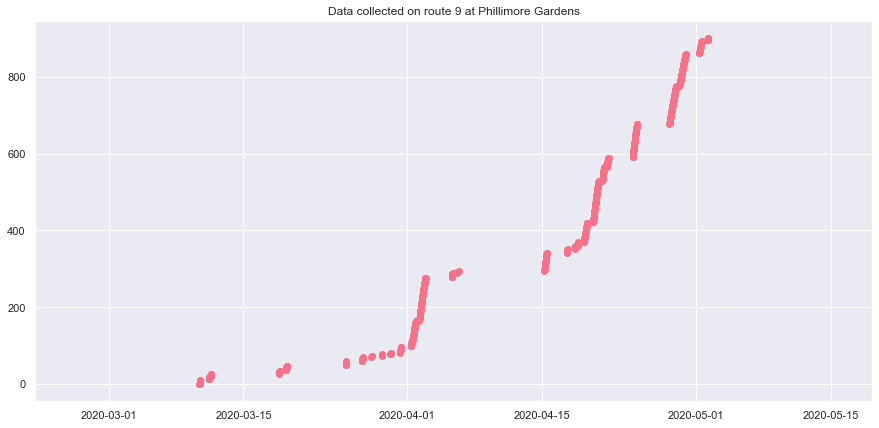

In [106]:
fig, ax = plt.subplots(figsize=(15,7))
x = [convert_time_to_datetime(i) for i in stop_b9['time_of_arrival']]
ax.scatter(x, [i for i in range(0, len(x))])
# ax.set_xlim([dt.datetime(2020, 4, 15, 2), dt.datetime(2020, 5, 10, 22, 59, 59)])
ax.set_title("Data collected on route 9 at Phillimore Gardens")
plt.show()

In [107]:
# Getting predicted arrival times for buses on route 9 for a gap of 5 stops.
"""
preds_9 = predicted arrival times
accs_9 = actual arrival times
req_timesx_9 = request times that returned valid values
preds_jrny_9 = predicted journey times (in minutes)
accs_jrny_9 = actual journey times (in minutes)
"""
weights = {"10": 0.6, "20": 0.25, "40": 0.1, "80": 0.04, "120": 0.01}
preds_9, accs_9, req_timesx_9, preds_jrny_9, accs_jrny_9 = eval_historical_model(weights, "2020-04-16 03:00:00", "2020-04-30 23:59:59", stop_a9, stop_b9, stop_a_id9, stop_b_id9)

['2020-04-16 08:27:09', '2020-04-16 09:30:43', '2020-04-16 10:55:51', '2020-04-16 12:24:36', '2020-04-16 14:41:20', '2020-04-16 15:30:36', '2020-04-16 15:58:35', '2020-04-16 19:01:20', '2020-04-16 22:17:36', '2020-04-17 01:05:49', '2020-04-17 01:33:41', '2020-04-17 12:42:52', '2020-04-17 14:59:14', '2020-04-17 15:21:53', '2020-04-17 18:31:44', '2020-04-17 20:39:32', '2020-04-17 21:30:37', '2020-04-17 23:10:08', '2020-04-18 00:46:04', '2020-04-18 01:13:58', '2020-04-18 10:48:07', '2020-04-18 11:48:18', '2020-04-18 11:48:51', '2020-04-18 13:25:38', '2020-04-18 15:46:45', '2020-04-18 17:26:30', '2020-04-18 21:29:52', '2020-04-18 23:36:28', '2020-04-19 01:35:29', '2020-04-19 03:16:07', '2020-04-19 04:21:04', '2020-04-19 06:00:18', '2020-04-19 08:56:15', '2020-04-19 09:58:36', '2020-04-19 11:00:47', '2020-04-19 11:03:01', '2020-04-19 11:22:32', '2020-04-19 15:31:20', '2020-04-19 16:40:49', '2020-04-19 17:01:34', '2020-04-19 17:25:20', '2020-04-19 19:04:06', '2020-04-19 19:15:03', '2020-04-1

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-17 20:39:32
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-17 21:30:37
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-17 23:10:08
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Pre

There is no bus arriving at req_time
Request time is  2020-04-19 19:04:06
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-19 19:15:03
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-19 19:16:22
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-19 19:29:59
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and hav

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-21 15:59:05
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-21 20:12:07
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a and have an id match:  43
Number of buses that have feasible journey times:  11
Predicted journey time is  4.403869047619048
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-04-21 20:32:41
Number of buses that arrived at stop b within the past 2 hours:  12
Number of buses that left stop a an

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-23 22:04:01
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-23 23:00:42
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-24 01:44:51
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Pre

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-25 17:24:21
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-25 19:10:20
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-25 21:48:02
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Pre

Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-28 00:39:13
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-28 01:00:38
Number of buses that arrived at stop b within the past 2 hours:  0
Number of buses that left stop a and have an id match:  0
Number of buses that have feasible journey times:  0
Predicted journey time is  0.0
Couldn't find any journeys
Request time is  2020-04-28 05:33:26
Number of buses that arrived at stop b within the past 2 hours:  1
Number of buses that left stop a and have an id match:  1
Number of buses that have feasible journey times:  1
Pre

Number of buses that arrived at stop b within the past 2 hours:  10
Number of buses that left stop a and have an id match:  50
Number of buses that have feasible journey times:  6
Predicted journey time is  4.390277777777778
There are no buses due at this time from this stop
Cannot find correlating leaving bus.
Request time is  2020-04-29 22:45:04
Number of buses that arrived at stop b within the past 2 hours:  6
Number of buses that left stop a and have an id match:  27
Number of buses that have feasible journey times:  4
Predicted journey time is  4.545238095238094
Predicted arrival time is 2020-04-29 22:31:31.714286
There is no bus arriving at req_time
Request time is  2020-04-29 23:58:50
Number of buses that arrived at stop b within the past 2 hours:  4
Number of buses that left stop a and have an id match:  3
Number of buses that have feasible journey times:  2
Predicted journey time is  2.8071428571428565
There are no buses due at this time from this stop
Cannot find correlating 

In [108]:
len(preds_jrny_9)

20

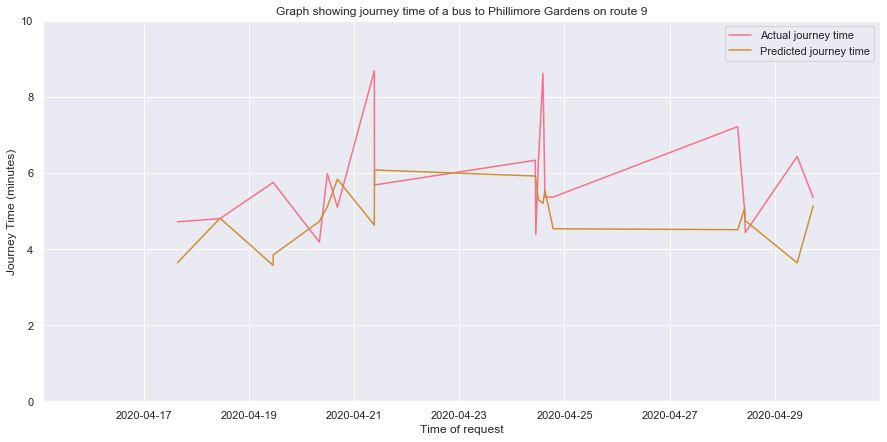

In [109]:
times_9 = [convert_time_to_datetime(t) for t in req_timesx_9]
actual_jrny_9 = [x.total_seconds() for x in accs_jrny_9]

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(times_9, actual_jrny_9, label="Actual journey time")
ax.plot(times_9, preds_jrny_9, label="Predicted journey time")
ax.set_xlabel("Time of request")
ax.set_ylabel("Journey Time (minutes)")
ax.set_xlim([dt.datetime(2020, 4, 15, 2), dt.datetime(2020, 4, 30, 23, 59, 59)])
ax.set_ylim(0, 10)
ax.set_title("Graph showing journey time of a bus to Phillimore Gardens on route 9")
ax.legend()

plt.show()

In [110]:
actual_seconds_9 = [a.timestamp() for a in accs_9]
pred_seconds_9 = [p.timestamp() for p in preds_9]

evs9 = explained_variance_score(actual_seconds_9, pred_seconds_9)
mape9 = mean_absolute_error(actual_seconds_9, pred_seconds_9)
mse9 = mean_squared_error(actual_seconds_9, pred_seconds_9)
rmse9 = np.sqrt(mse9)

print("Explain variance score: ", evs9)
print("Mean absolute percentage error: ", mape9)
print("Root mean square error: ", rmse9)

Explain variance score:  0.9999999263816924
Mean absolute percentage error:  73.41723225116729
Root mean square error:  88.09646678693788


### Putting it all together

The user gives their desired bus stop and bus route and gets a predicted arrival time back.

This would be the algorithm that runs on the mobile app when a user requests the predicted arrival time at a specific stop for a specific route (and direction)

In [151]:
def get_pred_and_actual_arrival_time(route, stop):
    # Will need to do something about inbound or outbound
    weights = {"10": 0.65, "20": 0.18, "40": 0.09, "80": 0.04, "120": 0.02}
    
    df = data[route]

    stop_b_entries = df.loc[(df['bus_stop_name'] == stop) & (df['direction'] == 'inbound')]
    [_, stop_b_id, _, _, _] = stop_b_entries.iloc[0]['vehicle_id'].split('_')
    
    b_stop_index = stops_in_sequence_inbound.get(route).index(stop)
    a_stop_index = b_stop_index - 5 if (b_stop_index - 5) >= 0 else 0 
    a_stop_name = stops_in_sequence_inbound.get(route)[a_stop_index]
    print("{} to {}".format(a_stop_name, stop))
    
    stop_a_entries = df.loc[(df['bus_stop_name'] == a_stop_name) & (df['direction'] == 'inbound')]
    [_, stop_a_id, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
    
    # req_time = dt.datetime.now()
    req_time = "2020-04-28 08:30:00"
    
    print("Request time is ", req_time)
    
    pred_arr = 0
    
    while pred_arr == 0:
        pred_jrny_time, most_recent_left = predict_journey_time(req_time, stop_a_entries, stop_b_entries, stop_a_id, weights)
        print("Predicted journey time is ", (pred_jrny_time)/60)
        
        if pred_jrny_time == 0:
            print("Unable to find any journeys")
            pred_arr = 0
        else:
            pred_arr, bus_to_track = predict_arrival_time(req_time, stop_a_entries, pred_jrny_time, most_recent_left)

        if pred_arr == 0:
            print("Couldn't find correlating leaving bus, go back 1 more stop")
            a_stop_index = a_stop_index - 1

            if a_stop_index < 0:
                print("No journeys found on entire route")
                return 0, 0

            a_stop_name = stops_in_sequence_inbound.get(route)[a_stop_index]
            stop_a_entries = df.loc[(df['bus_stop_name'] == a_stop_name) & (df['direction'] == 'inbound')]
            [_, stop_a_id, _, _, _] = stop_a_entries.iloc[0]['vehicle_id'].split('_')
            print("{} to {}".format(a_stop_name, stop))

    print("Predicted arrival time is {}".format(pred_arr))
    actual_arr = get_actual_times(stop_b_entries, req_time, bus_to_track, stop_b_id)
    
    if actual_arr is None:
        print("There is no bus arriving at req_time")
        return pred_arr, 0
    
    return pred_arr, actual_arr

In [152]:
user_route = "9"
user_stop = "Royal Albert Hall"

start = time.time()
predicted_arr_time, actual_arr_time = get_pred_and_actual_arrival_time(user_route, user_stop)
print("Total time ", (time.time() - start))

Phillimore Gardens to Royal Albert Hall
Request time is  2020-04-28 08:30:00
Number of buses that arrived at stop b within the past 2 hours:  14
Number of buses that left stop a and have an id match:  74
Number of buses that have feasible journey times:  13
Predicted journey time is  4.358983451536642
There are no buses due at this time from this stop
Couldn't find correlating leaving bus, go back 1 more stop
The Design Museum to Royal Albert Hall
Number of buses that arrived at stop b within the past 2 hours:  14
Number of buses that left stop a and have an id match:  72
Number of buses that have feasible journey times:  12
Predicted journey time is  4.76060606060606
There are no buses due at this time from this stop
Couldn't find correlating leaving bus, go back 1 more stop
Warwick Gardens to Royal Albert Hall
Number of buses that arrived at stop b within the past 2 hours:  14
Number of buses that left stop a and have an id match:  68
Number of buses that have feasible journey times: